### Udacity Data Science Nanodegree
### Project 1: Writing a Data Scientist Blog Post
---

# Part II - London Airbnb Data - EDA
## by Juanita Smith


- [Introduction](#intro)
- [Data gathering](#getdata)
- [Feature Engineering](#featureeng)
- [Step 1: Univariate Exploratoin](#univariate)
- [Step 2: Bivariate Exploratoin](#bivariate)
- [Step 3: Multivariate Exploratoin](#multivariate)
- [Conclusions](#conclusions)
- [References](#references)
- [Submission](#submission)

<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

### Context:
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in London, United Kingdom.


### Dictionary:

In Part I, Airbnb London listing data was cleaned, and only a subset of the available features was selected to support analysis of below questions.

**Recap of the origin of data:**

Airbnb activity is included for **London** and is a snapshot of booking availability on 8 June 2023

Data was downloaded from Airbnb [here](http://insideairbnb.com/get-the-data/). Scroll down to London section. 

To support this analysis, only listings and calendar data was needed.

Metadata are available [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

## Are you like me going the Taylor Swift concert in London next June and looking for the best place to stay ?

This project will focus on answering questions below, whilst this notebook focus on question 1 in blue

<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">1) Are some hosts running a business, and if so, what is the impact on price ?</span>
> - Can we identify businesses by the duration of rentals ? Are businesses focusing on short or long term term rentals? What impact have rental duration have on price ?
> - Are some hosts running a business with multiple listings ? If so, how does this affect the price ?


2) Host Analysis: How does **host excellence** influence price ?
> - Super hosts seems to describe their properties better, how does this effect price and availability ?


3) What effect does **star ratings** have on property price ?
> - Would a 5-star vs 3-star listing in the same location cost more ?


4) Predict average daily listing price
> - Knowing the impact of host excellence and star ratings above, could we make an accurate average daily price prediction ?


## Question 1: Are some hosts running a business, and if so, what is the impact on price ?

### Main feature(s) of interest

> I would expect commercial rentals to be lower in price per day, with a minimum rental period for longer periods 3 months and more

We are looking to classify rentals between individual or commercial rentals.

Main features of interest to help detect commercial rentals:
- Number of listings per host - hosts with more than 5 listings are unlikely be an individual person ?
- Type of properties/rooms - commercial listings might focus on renting an entire home or flat ?
- How many people listings can accommodate
- Number of reviews - does commercial listings receive more or less reviews ?
- Availability - long term rentals should have less availability if it's rented out for long periods ?
- Instantly bookable - commercial rentals for long stay might want to a credit check first ?
- Minimum and maximum nights per rental - it's unlikely that a rental with a minimum night of 3 months is a holiday rental
- Are the host living in the same area as the rented property ?

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import os
import missingno as msno
from datetime import datetime

# fuzzy compare neighborhood strings
from fuzzywuzzy import fuzz

# Entity recognition: is the host a person or business ?
import stanza

# from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

# clear the garbage to free memory as we are working with huge datasets
import gc 

# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
from project1_blog.src.utils import reduce_mem_usage, create_folder, entity_recognision
import project1_blog.src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# # use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# stop scientific notation on graphs
# pd.options.display.float_format = '{:.0f}'.format

In [2]:
# set default plot formatting and colors
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_SUB1, BASE_COLOR_SUB2, SYMBOLS = vs.set_plot_defaults()

In [3]:
# default file paths
FILE_NAME_RAW = '../data/clean/listing_clean.pkl'
FILE_NAME_CLEAN = '../data/clean/listing_clean.pkl'
FILE_NAME_ENHANCED = '../data/clean/listing_enhanced.pkl'

<a id='getdata'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Gather Data</span>

In [4]:
# load the cleaned file 
listing = pd.read_pickle(FILE_NAME_CLEAN)
listing.sample(5)

,listing_id,listing_url,name,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_has_about,host_has_neighborhood_overview,host_years_active,price_mean,private_bathroom
59778,842813855901725701,https://www.airbnb.com/rooms/842813855901725701,Rental unit in Greater London · ★3.75 · 1 bedr...,489558439,Imba,within an hour,97,100,False,Brixton Hill,False,True,Lambeth,51.449924,-0.123049,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,90,2,1125,23,51,81,101,8,8,2,2023-03-12,2023-05-21,3.75,4.00,4.13,3.75,4.00,3.75,3.75,True,16,16,0,0,2.67,False,False,1,90,True
24464,36927883,https://www.airbnb.com/rooms/36927883,Home in Greater London · ★4.96 · 1 bedroom · 1...,195967425,Mauricia,within an hour,100,96,False,LB of Havering,True,True,Havering,51.550705,0.207347,Private room in home,Private room,1,1.5,1.0,1.0,39,1,1125,30,60,90,90,54,17,2,2021-07-11,2023-06-01,4.96,4.93,4.96,4.96,4.96,4.85,4.98,False,3,0,3,0,2.32,False,True,5,39,False
51154,754431755473521267,https://www.airbnb.com/rooms/754431755473521267,Condo in Greater London · 2 bedrooms · 2 beds ...,37385906,Daniel,NaN,0,75,False,NaN,True,True,Hackney,51.530360,-0.095100,Entire condo,Entire home/apt,4,2.0,2.0,2.0,145,3,11,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1,0,0,NaN,False,False,8,446,True
47441,705697481522891006,https://www.airbnb.com/rooms/705697481522891006,Rental unit in Greater London · ★4.44 · 2 bedr...,318303638,Francesca Smarthost,within an hour,100,99,False,Fulham,True,True,Hammersmith and Fulham,51.468630,-0.185270,Entire rental unit,Entire home/apt,5,2.0,2.0,3.0,258,2,1125,17,46,76,154,16,16,1,2022-09-26,2023-06-03,4.44,4.50,4.44,4.13,4.50,4.56,4.38,True,12,12,0,0,1.87,True,True,4,347,True
26111,39258783,https://www.airbnb.com/rooms/39258783,Condo in London · 1 bedroom · 3 beds · 1.5 baths,168606573,Maria,within an hour,100,99,False,Kensington,True,True,Hammersmith and Fulham,51.497680,-0.210100,Entire condo,Entire home/apt,5,1.5,1.0,3.0,154,1,1125,0,0,8,283,2,0,0,2019-11-10,2019-11-10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,False,14,14,0,0,0.05,False,True,5,154,True


In [5]:
# make sure datatypes were preserved from cleaning step
listing.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69577 entries, 0 to 69576
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_id                                    69577 non-null  int64  
 1   listing_url                                   69577 non-null  object 
 2   name                                          69577 non-null  object 
 3   host_id                                       69577 non-null  int64  
 4   host_name                                     69577 non-null  object 
 5   host_response_time                            52186 non-null  object 
 6   host_response_rate                            69577 non-null  int16  
 7   host_acceptance_rate                          69577 non-null  int16  
 8   host_is_superhost                             69577 non-null  bool   
 9   host_neighbourhood                            37903 non-null 

In [6]:
listing.shape

(69577, 51)

<a id='featureeng'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Feature engineering</span>

#### Create new feature to indicate if host lives in the same neighborhood as the listing

In [7]:
# How many hosts lives in same neighbourhood ?
len(listing[listing['host_neighbourhood'] == listing['neighbourhood_cleansed']])

1591

In [8]:
# fill missing values with a string that will never match 'neighbourhood_cleansed' when compared
listing['host_neighbourhood'].fillna('Unknown', inplace=True)

# use fuzzywazzy to compare host vs listing neighborhood
listing['neighborhood_partial_ratio'] = listing.apply(lambda x: fuzz.partial_ratio(x['host_neighbourhood'], x['neighbourhood_cleansed']), axis=1)
listing['neighborhood_ratio'] = listing.apply(lambda x: fuzz.ratio(x['host_neighbourhood'], x['neighbourhood_cleansed']), axis=1)

In [9]:
listing[['neighborhood_ratio', 'neighborhood_partial_ratio', 'host_neighbourhood', 'neighbourhood_cleansed']].loc[(listing['neighborhood_partial_ratio'] >= 70) & (listing['neighborhood_partial_ratio'] < 100)].drop_duplicates()

,neighborhood_ratio,neighborhood_partial_ratio,host_neighbourhood,neighbourhood_cleansed
1130,79,90,LB of Hammersmith & Fulham,Hammersmith and Fulham
2909,45,78,Islington,Kensington and Chelsea
4583,58,75,Harringay Ladder,Haringey
5601,74,82,Kensington,Islington
7751,72,73,Walthamstow,Waltham Forest
11906,47,73,LB of Brent,Barnet
12392,48,71,Hither Green,Greenwich
25072,80,71,Brockley,Bromley
27843,82,75,Harringay,Haringey
32111,47,70,Kensington,Kingston upon Thames


In [10]:
# if matching score exceed 90%, set same location to True
listing['host_same_location'] = np.where(listing['neighborhood_partial_ratio'] >= 90, True, False)
listing.drop(['neighborhood_partial_ratio', 'neighborhood_ratio'], inplace=True, axis=1)

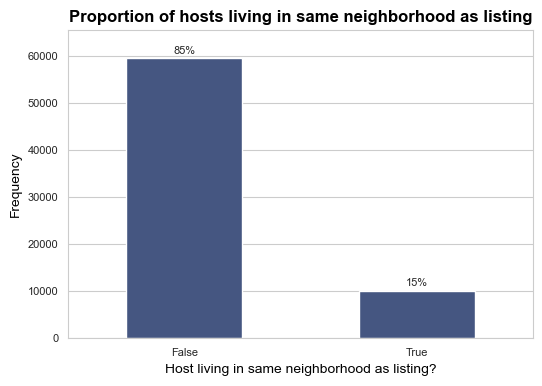

In [11]:
# neighborhood matching was drastically improved

plt.figure(figsize=(6,4))
ax = sns.countplot(data=listing, x='host_same_location', color=BASE_COLOR, width=0.5)

for bars in ax.containers: 
    labels = [f"{x/listing.shape[0]:.0%}" for x in bars.datavalues]
    ax.bar_label(bars, labels, padding=2)
    
ax.margins(y=0.1)
    
plt.ylabel('Frequency')
plt.xlabel('Host living in same neighborhood as listing?')
plt.title('Proportion of hosts living in same neighborhood as listing')
plt.show()

<a id='univariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Univariate Analysis</span>

Questions to guide the analysis:
- What is the distribution of minimum and maximum nights stay ?
- What kind of properties have minimum stay over 30 days ?
- Investigate number of listings per hosts
- As price is centre to all the questions and the final goal of the project, let's analyse it's distribution and cleanup outliers

In [12]:
# numerical columns of interest
cols_of_interest = ['calculated_host_listings_count', 'accommodates', 'number_of_reviews_ltm', 'availability_365', 'instant_bookable', 
                    'minimum_minimum_nights', 'minimum_maximum_nights', 'host_same_location', 'price_mean']

<span style="color:blue; font-size:16px; font-family: Calibri;">Let's get a first impression how features of interest are distributed</span>

In [13]:
listing[cols_of_interest].astype(int).describe([0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999], include='all')

,calculated_host_listings_count,accommodates,number_of_reviews_ltm,availability_365,instant_bookable,minimum_minimum_nights,minimum_maximum_nights,host_same_location,price_mean
count,69577.000000,69577.000000,69577.000000,69577.000000,69577.000000,69577.000000,69577.000000,69577.000000,69577.000000
mean,19.587335,3.182302,6.944450,140.238441,0.312848,5.664171,650.289780,0.145795,217.728215
std,63.187990,2.009477,13.800293,134.641663,0.463656,24.313212,490.692058,0.352903,447.976436
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,3.000000,0.000000,1.000000,100.000000,0.000000,71.000000
50%,2.000000,2.000000,2.000000,92.000000,0.000000,2.000000,365.000000,0.000000,129.000000
75%,7.000000,4.000000,8.000000,279.000000,1.000000,4.000000,1125.000000,0.000000,235.000000
85%,20.000000,5.000000,14.000000,331.000000,1.000000,5.000000,1125.000000,0.000000,325.000000
90%,41.000000,6.000000,20.000000,348.000000,1.000000,7.000000,1125.000000,1.000000,420.000000
95%,99.000000,7.000000,32.000000,363.000000,1.000000,14.000000,1125.000000,1.000000,651.000000


>**Observation:**
>   - Mean price have a high standard deviation of £493, whilst the mean is £220. There are some big outliers with mean price £58,420! 
>   - Hosts generally do not live in the same location as the rented property
>   - Properties are not normally instantly bookable
>   - Minimum nights are normally < 14 days at 95% percentile, with some huge outliers present at 1,112 days.
>   - There are not a lot of variation in maximum nights, it's therefore not interesting to identify commercial listings or any price predictions. 
>   - Most hosts have < 10 listed properties at 75% percentile. Some hosts have 543 listings, this must be a business !  
>
>**Summary**: there are generally some big outliers in the 90% percentile and higher. Are these 'dirty' data, or indicators of commercial listings ?

<span style="color:blue; font-size:18px; font-family: Calibri;"> A deeper look at how minimum and maximum nights are distributed</span>

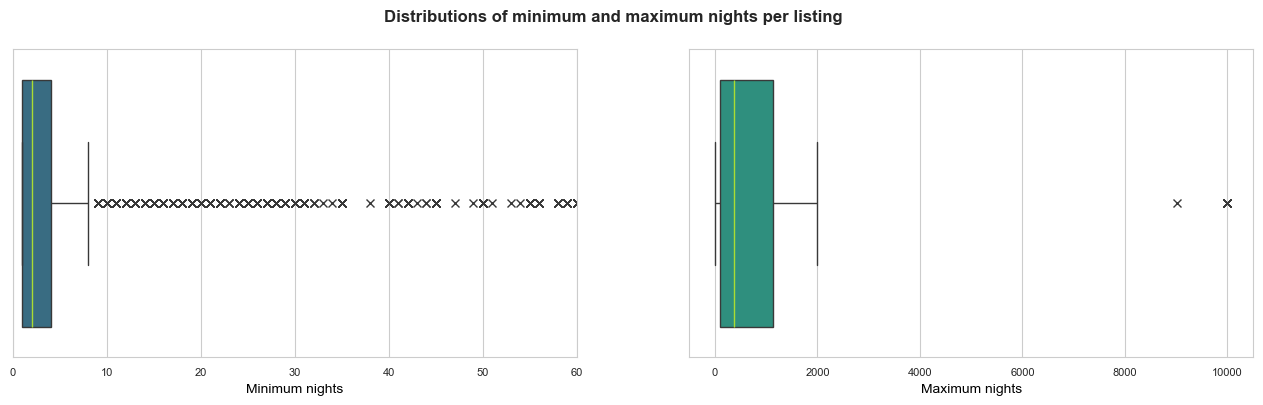

In [14]:
# plot distribution of minimum and maximum nights using boxplots
fig, ax = plt.subplots(ncols=2, figsize=(16,4))   

plt.subplot(1,2,1)
sns.boxplot(data=listing, x='minimum_minimum_nights', color = BASE_COLOR_SUB1, flierprops={"marker": "x"}, medianprops={"color": BASE_HIGHLIGHT })
plt.xlabel('Minimum nights')
plt.xlim(0,60)

plt.subplot(1,2,2)
sns.boxplot(data=listing, x='minimum_maximum_nights', color = BASE_COLOR_SUB2, flierprops={"marker": "x"}, medianprops={"color": BASE_HIGHLIGHT })
plt.xlabel('Maximum nights')

plt.suptitle('Distributions of minimum and maximum nights per listing')
plt.show()

>**Observation:**
>   - Minimum nights have lots of outliers over 10 days
>   - Maximum nights have some outliers over 1125 days

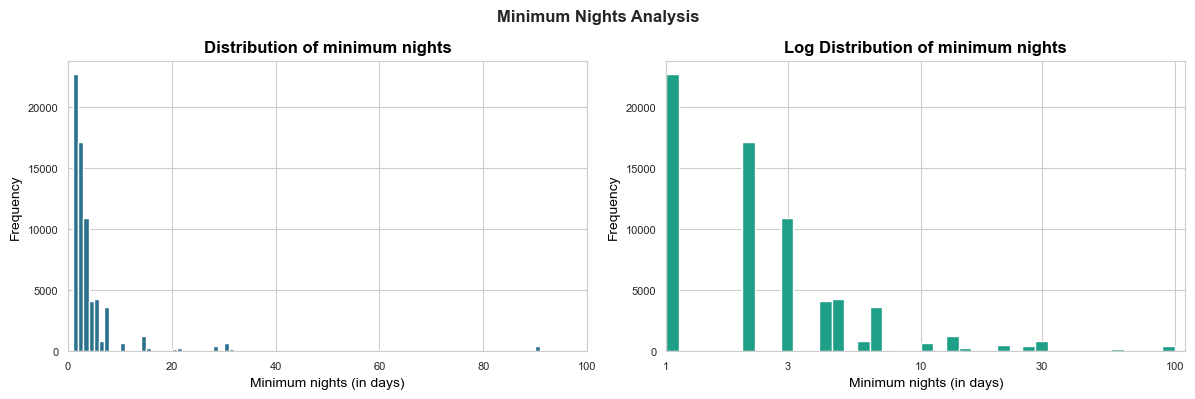

In [15]:
# distribution of minimum nights

plt.figure(figsize=[12,4])

# plot 1
plt.subplot(1, 2, 1)
bin_size = 1
xbins = np.arange(0, listing['minimum_minimum_nights'].max()+bin_size, bin_size)
ax1 = plt.hist(data=listing, x='minimum_minimum_nights', bins=xbins, color=BASE_COLOR_SUB1)
plt.xlim(0,100)
plt.xlabel('Minimum nights (in days)')
plt.ylabel('Frequency')
plt.title('Distribution of minimum nights')


# plot 2 on log scale
ax2 = plt.subplot(1, 2, 2)
log_binsize = 0.05
xbins= 10 ** np.arange(0, np.log10(listing['minimum_minimum_nights'].max())+log_binsize, log_binsize)
xticks = [1, 3, 10, 30, 100, 300]
xlabels = ['{}'.format(tick) for tick in xticks]

plt.hist(data=listing, x='minimum_minimum_nights', bins=xbins, color=BASE_COLOR_SUB2)
plt.xscale('log')
plt.xticks(xticks, xlabels)
plt.xlabel('Minimum nights (in days)')
plt.ylabel('Frequency')
plt.title('Log Distribution of minimum nights')
plt.suptitle('Minimum Nights Analysis')
plt.xlim(1,110)

plt.tight_layout()

>**Observation:**
>    - Minimum nights is right skewed, even when we plot it on a log scale
>    - Minimum nights normally have values up to 3 days, which match with 50% percentile
>    - Most listing have minimum nights up to 30 days, which match with 95% percentile

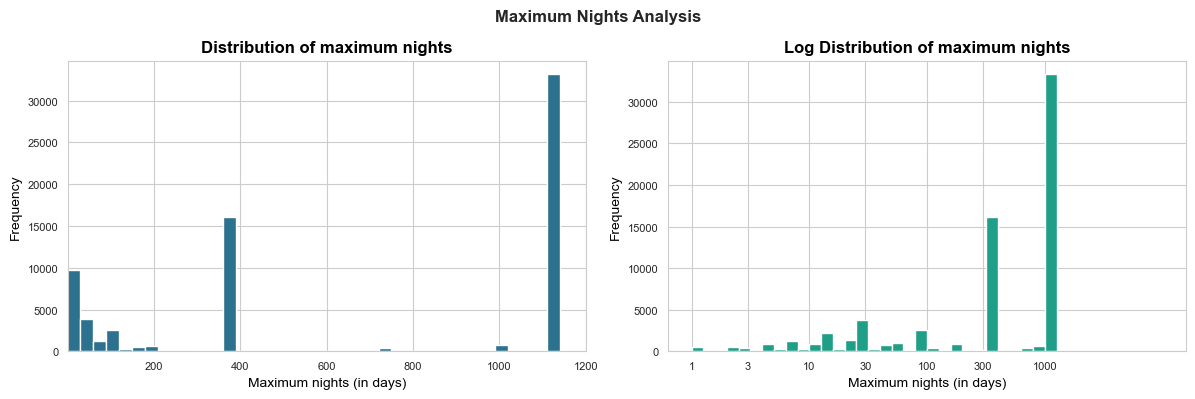

In [16]:
# distribution of maximum nights

plt.figure(figsize=[12,4])

ax1 = plt.subplot(1, 2, 1)
steps = 30
xbins = np.arange(0, listing['minimum_maximum_nights'].max()+steps, steps)
plt.hist(data=listing, x='minimum_maximum_nights', bins=xbins, color=BASE_COLOR_SUB1)
plt.xlabel('Maximum nights (in days)')
plt.ylabel('Frequency')
plt.title('Distribution of maximum nights')
plt.xlim(1, 1200)

ax2 = plt.subplot(1, 2, 2)
log_binsize = 0.1
xbins= 10 ** np.arange(0, np.log10(listing['minimum_maximum_nights'].max())+log_binsize, log_binsize)
xticks = [1, 3, 10, 30, 100, 300, 1000]
xlabels = ['{}'.format(tick) for tick in xticks]
plt.hist(data=listing, x='minimum_maximum_nights', bins=xbins, color=BASE_COLOR_SUB2)
plt.xscale('log')
plt.xticks(xticks, xlabels)
plt.xlabel('Maximum nights (in days)')
plt.ylabel('Frequency')
plt.title('Log Distribution of maximum nights')
plt.ticklabel_format(style='plain', axis='y')
# plt.xlim(1, 110)
plt.suptitle('Maximum Nights Analysis')

plt.tight_layout()

>**Observation:**
>    - We can observe 2 main peaks, at the 1 year mark and again on 1125 days. Some properties have max days < 200 days which indicate shorter term rentals

#### What kind of properties have minimum stay over 300 days ?

A minimum stay > 300 nights for a holiday rental seems excessive, lets have a deeper look

In [17]:
longterm_rentals = listing[listing['minimum_minimum_nights'] > 300]
longterm_rentals.shape

(117, 52)

In [18]:
longterm_rentals[cols_of_interest].astype(int).describe()

,calculated_host_listings_count,accommodates,number_of_reviews_ltm,availability_365,instant_bookable,minimum_minimum_nights,minimum_maximum_nights,host_same_location,price_mean
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,46.829060,2.854701,0.401709,169.188034,0.376068,457.495726,928.410256,0.136752,311.239316
std,96.913158,1.862817,2.495029,149.091787,0.486481,214.023429,303.419340,0.345063,872.623874
min,1.000000,1.000000,0.000000,0.000000,0.000000,350.000000,360.000000,0.000000,19.000000
25%,1.000000,2.000000,0.000000,0.000000,0.000000,364.000000,1000.000000,0.000000,63.000000
50%,3.000000,2.000000,0.000000,180.000000,0.000000,365.000000,1125.000000,0.000000,129.000000
75%,23.000000,4.000000,0.000000,362.000000,1.000000,365.000000,1125.000000,0.000000,265.000000
max,280.000000,11.000000,20.000000,365.000000,1.000000,1125.000000,1125.000000,1.000000,8000.000000


>**Observation:**
>    - Generally, listings with high amount of minimum days have no reviews in the last year with very little overall reviews
>    - Hosts are generally not in the same location 

In [19]:
longterm_rentals.sample(5)

,listing_id,listing_url,name,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_has_about,host_has_neighborhood_overview,host_years_active,price_mean,private_bathroom,host_same_location
29353,43402696,https://www.airbnb.com/rooms/43402696,Rental unit in Greater London · 2 bedrooms · 2...,345760385,Nikunjkumar,NaN,0,0,False,South Kensington,True,True,Kensington and Chelsea,51.50062,-0.180800,Private room in rental unit,Private room,2,1.5,2.0,2.0,100,365,1000,30,60,90,180,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,23,0,22,1,NaN,False,True,3,129,True,False
53211,776565018486647143,https://www.airbnb.com/rooms/776565018486647143,Rental unit in Greater London · 3 bedrooms · 3...,314162972,Blueground,within an hour,100,97,False,Shoreditch,True,True,Westminster,51.52070,-0.170803,Entire rental unit,Entire home/apt,6,3.0,3.0,3.0,529,360,1125,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,280,280,0,0,NaN,True,True,4,432,True,False
29276,43403558,https://www.airbnb.com/rooms/43403558,Rental unit in Greater London · 2 bedrooms · 1...,345760385,Nikunjkumar,NaN,0,0,False,South Kensington,True,True,Westminster,51.50224,-0.182970,Private room in rental unit,Private room,2,1.0,2.0,1.0,100,365,1000,30,60,90,180,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,23,0,22,1,NaN,False,True,3,129,False,False
29351,43402690,https://www.airbnb.com/rooms/43402690,Rental unit in Greater London · 1 bedroom · 1 ...,345760385,Nikunjkumar,NaN,0,0,False,South Kensington,True,True,Kensington and Chelsea,51.50089,-0.182790,Private room in rental unit,Private room,2,1.0,1.0,1.0,100,365,1000,30,60,90,180,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,23,0,22,1,NaN,False,True,3,129,True,False
20459,30289084,https://www.airbnb.com/rooms/30289084,Rental unit in Greater London · ★4.43 · 1 bedr...,219078771,Mubashira,within an hour,100,0,False,Kensington,True,True,Kensington and Chelsea,51.49711,-0.187410,Private room in rental unit,Private room,1,1.0,1.0,1.0,40,365,365,29,59,89,364,61,0,0,2019-01-13,2019-11-04,4.43,4.6,4.4,4.95,4.93,4.9,4.5,False,1,0,1,0,1.14,False,True,5,40,True,True


>**Observation:**
>    
>After spot checking some of these properties in airbnb directly, it does not seem like long term rentals but rather messy data. It's quite weird for example how listing `9101592` has a minimum stay of over 600 days, but it's no where reflected in the comments or past reviews that this is a long term rental. Could it be that hosts put the minimum nights up when they want to avoid renting ? 

In [20]:
# lets look at more realistic examples of minimum nights
listing[(listing['minimum_minimum_nights']) > 30].head()

,listing_id,listing_url,name,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_has_about,host_has_neighborhood_overview,host_years_active,price_mean,private_bathroom,host_same_location
59,228195,https://www.airbnb.com/rooms/228195,Rental unit in London · ★4.74 · 2 bedrooms · 2...,940283,Andrew,within a few hours,100,73,True,Earls Court,True,True,Kensington and Chelsea,51.48829,-0.18905,Entire rental unit,Entire home/apt,3,1.0,2.0,2.0,95,75,99,0,0,0,89,71,3,0,2012-12-31,2022-09-05,4.74,4.88,4.94,4.96,4.97,4.87,4.84,False,1,1,0,0,0.56,True,True,12,97,True,False
61,324055,https://www.airbnb.com/rooms/324055,Home in London · 1 bedroom · 1 bed,1664001,Ganesan,a few days or more,0,0,False,Unknown,True,False,Newham,51.55311,0.02273,Private room in home,Private room,2,NaN,1.0,1.0,29,150,365,30,60,90,365,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,0,1,0,NaN,True,False,11,29,False,False
89,238711,https://www.airbnb.com/rooms/238711,Rental unit in Kensington · ★4.86 · 1 bedroom ...,1251427,Benjamin,within an hour,100,100,True,Bayswater,True,True,Kensington and Chelsea,51.51156,-0.19579,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,150,90,1125,0,7,37,59,189,0,0,2011-10-20,2020-01-02,4.86,4.93,4.77,4.89,4.95,4.96,4.76,True,2,2,0,0,1.33,True,True,12,150,True,False
121,343848,https://www.airbnb.com/rooms/343848,Home in Enfield · ★4.86 · 1 bedroom · 2 beds ·...,1744522,Denise,within a few hours,100,93,False,LB of Enfield,True,True,Enfield,51.65075,-0.11841,Private room in home,Private room,3,1.5,1.0,2.0,41,180,1125,0,0,0,251,50,0,0,2012-05-28,2019-11-29,4.86,4.96,4.90,4.98,4.92,4.61,4.90,False,4,1,3,0,0.37,True,True,11,41,False,True
264,388387,https://www.airbnb.com/rooms/388387,Home in Buckhurst Hill · 1 bedroom · 1 bed · 1...,1943308,Maurizio,NaN,0,0,False,Unknown,True,True,Redbridge,51.61587,0.04680,Private room in home,Private room,2,1.0,1.0,1.0,50,300,300,30,60,90,180,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,0,1,0,NaN,False,False,11,50,False,False


>**Observation**:
>    - 228195 is the first real example spotted of a long term rental with minimum of 75 nights that I can actually book that is available.

In [21]:
# drop outliers in minimum nights over 90 days and maximum nights > 1125
print(listing.shape)
rows_to_drop = listing[(listing['minimum_minimum_nights'] > 90) | (listing['minimum_maximum_nights'] > 1125)]
listing.drop(rows_to_drop.index, inplace=True, errors='ignore')
print(listing.shape)

(69577, 52)
(69185, 52)


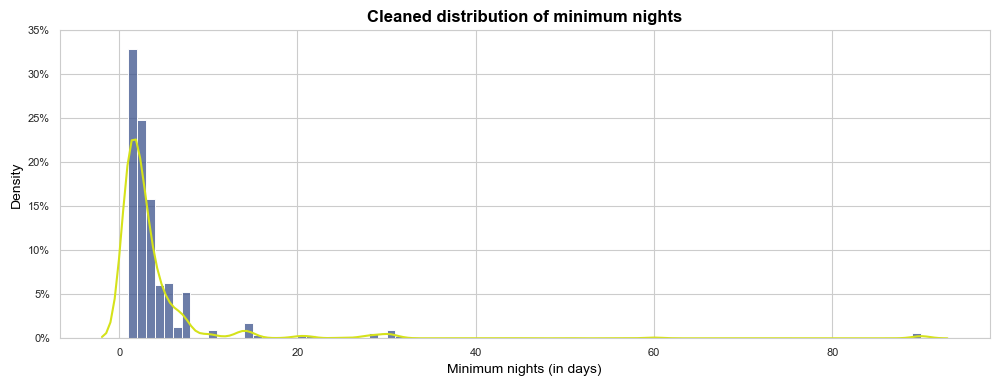

In [22]:
# distribution of minimum nights after outliers were removed

plt.figure(figsize=[12,4])

xbin_size = 1
xbins = np.arange(0, listing['minimum_minimum_nights'].max()+xbin_size, xbin_size)

yticks = np.arange(0, 0.4, 0.05)
ylabels = [f'{y*100:,.0f}%'.format(y) for y in yticks]

sns.histplot(listing['minimum_minimum_nights'], bins=xbins, color=BASE_COLOR, stat='density')
sns.kdeplot(listing['minimum_minimum_nights'], color=BASE_HIGHLIGHT_INTENSE)

# plt.xlim(1,32)
plt.yticks(yticks, ylabels)
plt.xlabel('Minimum nights (in days)')
plt.ylabel('Density')
plt.title('Cleaned distribution of minimum nights')


plt.show()

In [23]:
listing.minimum_minimum_nights.describe([0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.9999])

count     69185.000000
mean          4.359341
std           9.077002
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
90%           7.000000
95%          14.000000
99%          45.000000
99.99%       90.000000
max          90.000000
Name: minimum_minimum_nights, dtype: float64

>**Observation**:
>    - It seems normal to have minimum days up to 7, but not so common beyond that

<span style="color:blue; font-size:18px; font-family: Calibri;">Number of listings per host analysis: Analyse how many listings hosts have? Are there hosts with lots of listings that could be running a business instead ?</span>

In [24]:
# Host data are duplicated for each of its listings. Get unique host data
host_listing_cols = ['host_id', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
host_listings = listing[host_listing_cols].copy()
host_listings.drop_duplicates(inplace=True)
host_listings.shape

(39714, 5)

In [25]:
host_listings.describe([0.25, 0.5, 0.75, 0.9, 0.99, 0.9999])

,host_id,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
count,3.971400e+04,39714.000000,39714.000000,39714.000000,39714.000000
mean,1.419929e+08,1.768595,1.097573,0.655789,0.009518
std,1.609671e+08,5.587476,4.653704,2.145517,0.161702
min,2.594000e+03,1.000000,0.000000,0.000000,0.000000
25%,1.899699e+07,1.000000,0.000000,0.000000,0.000000
50%,6.407183e+07,1.000000,1.000000,0.000000,0.000000
75%,2.250062e+08,1.000000,1.000000,1.000000,0.000000
90%,4.480766e+08,2.000000,1.000000,1.000000,0.000000
99%,5.126534e+08,13.000000,10.000000,5.000000,0.000000
99.99%,5.186930e+08,229.492400,225.148000,63.401800,8.028700


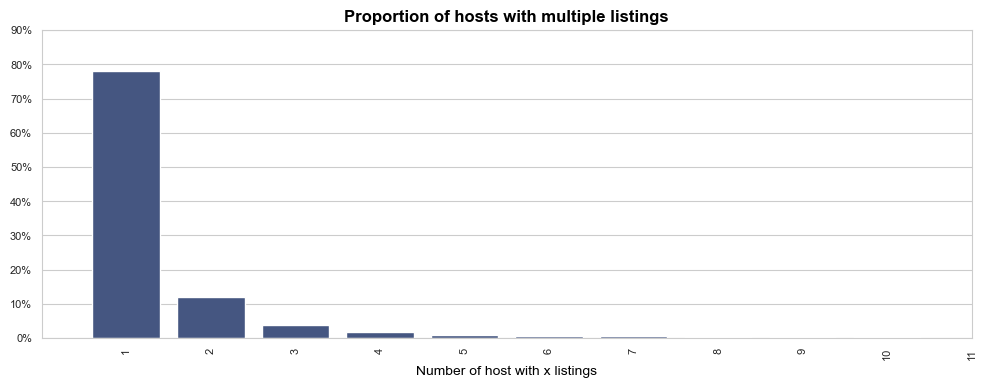

In [26]:
plt.figure(figsize=(12,4))
sns.countplot(data=host_listings, x='calculated_host_listings_count', stat='percent', color=BASE_COLOR)
plt.xticks(rotation=90)
plt.xlim(-1,10)
plt.xlabel('Number of host with x listings')
plt.ylabel('')
plt.title('Proportion of hosts with multiple listings')
          
ticks = np.arange(0, 100, 10) 
labels = ['{}%'.format(tick) for tick in ticks]
plt.yticks(ticks, labels)          
          
plt.show()

>**Observation**:
>    - 90% hosts have only 1 or 2 listings
>    - Outlier at 99 percentile shows hosts with over 500 listings exists, this must be a business !

#### Which hosts have over 500 listings ?

In [27]:
print('Hosts with over 100 listings: {}'.format(len(host_listings[host_listings['calculated_host_listings_count'] > 500])))

Hosts with over 100 listings: 1


In [28]:
host_listings[host_listings['calculated_host_listings_count'] > 500]

,host_id,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
28996,129230780,543,264,279,0


In [29]:
listing[listing['host_id'] == 129230780][:5]

,listing_id,listing_url,name,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_has_about,host_has_neighborhood_overview,host_years_active,price_mean,private_bathroom,host_same_location
28996,42940031,https://www.airbnb.com/rooms/42940031,Rental unit in Greater London · 1 bedroom · 1 ...,129230780,STK Homes,within an hour,90,76,False,Westminster,True,True,Westminster,51.49647,-0.13203,Private room in rental unit,Private room,2,1.0,1.0,1.0,1880,3,1125,29,59,89,179,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,543,264,279,0,NaN,True,True,6,1880,False,True
28998,42940407,https://www.airbnb.com/rooms/42940407,Rental unit in Greater London · Studio · 1 bed...,129230780,STK Homes,within an hour,90,76,False,Westminster,True,True,Westminster,51.49467,-0.13226,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,1880,3,1125,29,59,89,179,1,0,0,2020-11-04,2020-11-04,4.0,4.0,3.0,5.0,5.0,5.0,4.0,False,543,264,279,0,0.03,True,True,6,1880,True,True
29382,43797523,https://www.airbnb.com/rooms/43797523,Rental unit in London · 1 bedroom · 1 bed · 1 ...,129230780,STK Homes,within an hour,90,76,False,Westminster,True,True,Westminster,51.49424,-0.13103,Private room in rental unit,Private room,2,1.0,1.0,1.0,1570,1,1125,29,59,89,364,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,543,264,279,0,NaN,True,True,6,1570,False,True
29818,44312935,https://www.airbnb.com/rooms/44312935,Rental unit in Greater London · 2 bedrooms · 1...,129230780,STK Homes,within an hour,90,76,False,Westminster,True,True,Westminster,51.49653,-0.13082,Private room in rental unit,Private room,2,1.0,2.0,1.0,1570,1,1125,29,59,89,364,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,543,264,279,0,NaN,True,True,6,1570,False,True
29822,44313204,https://www.airbnb.com/rooms/44313204,Rental unit in Greater London · 2 bedrooms · 1...,129230780,STK Homes,within an hour,90,76,False,Westminster,True,True,Westminster,51.49419,-0.13266,Private room in rental unit,Private room,2,1.0,2.0,1.0,1570,1,1125,29,59,89,364,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,543,264,279,0,NaN,True,True,6,1570,False,True


>**Observation**:
>- Host name is indeed a business name 'STK Homes'
>- Mean price is very high over 1000k per night in comparison with other listings this is excessive
>- As neighborhood, latitude and longitude are the same for many listings, it could be the same building like a block of flats but we don't have enough data to proof this

#### Inspect the properties of hosts with 50 listings as it's not so accessive

In [30]:
listing[listing['calculated_host_listings_count'] == 50].head()

,listing_id,listing_url,name,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_has_about,host_has_neighborhood_overview,host_years_active,price_mean,private_bathroom,host_same_location
3248,5827987,https://www.airbnb.com/rooms/5827987,Rental unit in London · ★4.50 · 2 bedrooms · 2...,30253178,Alisha,within an hour,94,98,False,Fulham,True,True,Hammersmith and Fulham,51.48499,-0.19807,Entire rental unit,Entire home/apt,4,2.0,2.0,2.0,218,3,1125,7,7,7,7,32,1,0,2015-07-13,2022-08-26,4.50,4.31,4.47,4.81,4.25,4.59,4.39,True,50,48,2,0,0.33,True,True,8,257,True,True
3729,6669426,https://www.airbnb.com/rooms/6669426,Rental unit in London · ★4.43 · 1 bedroom · 1 ...,30253178,Alisha,within an hour,94,98,False,Fulham,True,True,Hammersmith and Fulham,51.48783,-0.21232,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,188,3,1125,6,6,6,6,14,1,0,2015-12-30,2023-04-18,4.43,4.71,4.93,4.50,4.71,4.79,4.15,True,50,48,2,0,0.15,True,False,8,193,True,True
4556,7740789,https://www.airbnb.com/rooms/7740789,Condo in London · ★4.64 · 2 bedrooms · 2 beds ...,30253178,Alisha,within an hour,94,98,False,Fulham,True,True,Ealing,51.51159,-0.30549,Entire condo,Entire home/apt,4,1.0,2.0,2.0,258,3,1125,21,21,21,21,28,3,0,2015-12-26,2023-04-18,4.64,4.61,4.71,4.68,4.36,4.75,4.14,True,50,48,2,0,0.31,True,True,8,232,True,False
5000,8263633,https://www.airbnb.com/rooms/8263633,Serviced apartment in London · ★4.40 · 1 bedro...,42653212,Nell Gwynn Chelsea Accommodation,within a day,57,82,False,Chelsea,True,True,Kensington and Chelsea,51.49268,-0.16422,Entire serviced apartment,Entire home/apt,4,1.0,1.0,2.0,254,1,1,9,16,31,302,10,2,0,2016-06-25,2022-07-20,4.40,4.70,4.80,4.70,4.50,5.00,4.30,True,50,33,0,0,0.12,True,True,8,272,True,True
5210,8727124,https://www.airbnb.com/rooms/8727124,Serviced apartment in London · ★4.90 · Studio ...,42653212,Nell Gwynn Chelsea Accommodation,within a day,57,82,False,Chelsea,True,True,Kensington and Chelsea,51.49359,-0.16439,Entire serviced apartment,Entire home/apt,4,1.0,0.0,2.0,201,1,1,3,13,30,274,21,8,1,2016-01-03,2023-05-25,4.90,4.76,4.86,4.76,4.81,4.90,4.71,True,50,33,0,0,0.23,True,True,8,247,True,True


>**Observation**:
>- Interesting for these properties instant bookable is set to True
>- The last 2 records does not have host name as person's name, but again a company name

<span style="color:blue; font-size:18px; font-family: Calibri;">Entity recognition: Could we easily identify individual persons from businesses using entity detection from stanza library?</span>

In [31]:
# Display unique host names with more than 2 listings
names = list(listing[listing['calculated_host_listings_count'] > 2]['host_name'].unique())
len(names)

2558

In [32]:
# when running for first time uncomment
# stanza.download('en') # download English model

In [33]:
# when running for first time uncomment
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

# nlp = stanza.Pipeline(lang='en', processors='tokenize,ner', download_method=None)

2023-11-07 16:21:34 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-11-07 16:21:37 INFO: Loading these models for language: en (English):
| Processor | Package          |
--------------------------------
| tokenize  | combined         |
| ner       | ontonotes_charlm |

2023-11-07 16:21:37 INFO: Using device: cpu
2023-11-07 16:21:37 INFO: Loading: tokenize
2023-11-07 16:21:37 INFO: Loading: ner
2023-11-07 16:21:37 INFO: Done loading processors!


In [34]:
ents = {}
ent_name = []

for name in names:
    ent = entity_recognision(name, nlp)
    ents[name] = ent 
    
# build a dataframe with new boolen features 'is_business'
data = {'host_name': ents.keys(), 'entity': ents.values()}
df_ents = pd.DataFrame.from_dict(data)  
df_ents['is_business'] = np.where(df_ents['entity'] == 'ORG', True, False).astype(bool)
df_ents.drop('entity', inplace=True, axis=1)

In [35]:
df_ents.sample(15)

,host_name,is_business
1236,José Luis (Joe),False
604,Georgiana,False
2056,Ace Suites,False
1430,Flavia,False
2552,Eduarda,False
1686,Lydia,False
204,Brian,False
1790,Q,False
205,Jely,False
951,Hayley,False


In [36]:
# add new feature 'is_business' to listing dataset
print('Records before merge: {}'.format(listing.shape))

# add new feature 'entity' to listing dataset
listing = listing.merge(df_ents, how='left', on='host_name')

print('Records after merge: {}'.format(listing.shape))

Records before merge: (69185, 52)
Records after merge: (69185, 53)


In [37]:
# records where listing < 2 will have missing values, default to a person
listing['is_business'].fillna(False, inplace=True)

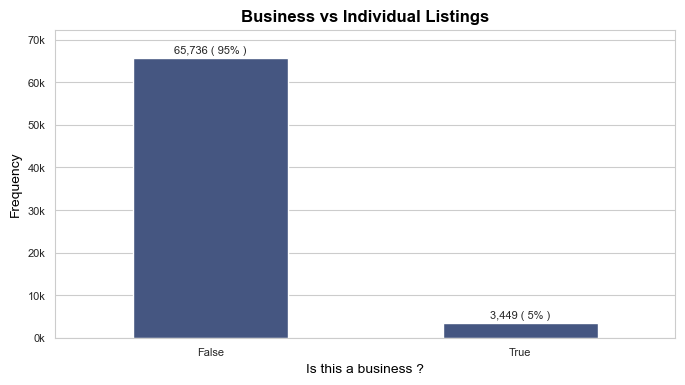

In [38]:
# plot proportion business vs individual
yticks = np.arange(0, listing.shape[0]+1000, 10000)
ylabels = ['{:,.0f}k'.format(tick/1000) for tick in yticks]

total = listing.is_business.count()
plt.figure(figsize=(8,4))
data = listing['is_business'].value_counts(normalize=False)
ax = sns.barplot(x=data.index, y=data, width=0.5, color=BASE_COLOR)

for c in ax.containers:
    labels =[f'{x:,.0f} ( {x/total*100:,.0f}% )' for x in c.datavalues]
    ax.bar_label(c, labels, padding=2)

ax.margins(y=0.1)

plt.yticks(yticks, ylabels)
plt.xlabel('Is this a business ?')
plt.ylabel('Frequency')
plt.title('Business vs Individual Listings')
plt.show()

>**Observation:**
>    +/- 3500 listings where detected where the host name was not a person's name, but rather a business like 'STK Homes'

#### Which kind of properties does hosts with multiple listings rent ?

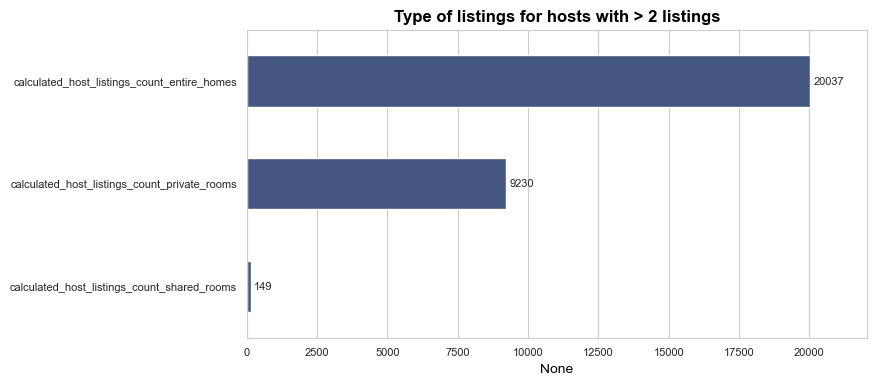

In [39]:
data = host_listings[host_listings['calculated_host_listings_count'] > 2].drop(['host_id', 'calculated_host_listings_count'], axis=1).sum()
ax = sns.barplot(y=data.index.values, x=data, width=0.5, color=BASE_COLOR)
    
for bars in ax.containers:
    ax.bar_label(bars, padding=2)
ax.margins(x=0.1)
    
plt.title('Type of listings for hosts with > 2 listings')

plt.show()

>**Observation:**
    - hosts with multiple listings mainly rent out entire homes

<span style="color:blue; font-size:18px; font-family: Calibri;">Price distribution: Let's analyse price distribution analysis to remove outliers</span>

In [40]:
listing['price_mean'].describe([0.01, 0.1, 0.25, 0.5, 0.8, 0.9, 0.95, 0.99, 0.9999])

count     69185.000000
mean        216.943254
std         437.515669
min           0.000000
1%           25.000000
10%          44.000000
25%          71.000000
50%         130.000000
80%         272.000000
90%         420.000000
95%         650.000000
99%        1570.000000
99.99%    10000.000000
max       58420.000000
Name: price_mean, dtype: float64

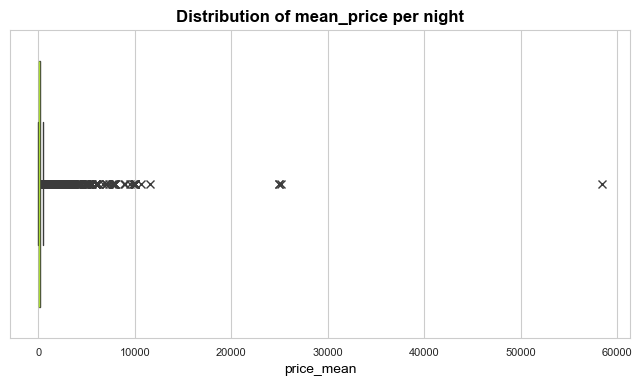

In [41]:
sns.boxplot(data=listing, x='price_mean', color = BASE_COLOR, flierprops={"marker": "x"}, medianprops={"color": BASE_HIGHLIGHT})
plt.title('Distribution of mean_price per night')
plt.show()

In [42]:
# Investigate some outlier prices
listing[listing['price_mean'] > 5000]

,listing_id,listing_url,name,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_has_about,host_has_neighborhood_overview,host_years_active,price_mean,private_bathroom,host_same_location,is_business
1724,2851908,https://www.airbnb.com/rooms/2851908,Rental unit in London · ★5.0 · 1 bedroom · 1 b...,14582703,K,NaN,0,0,False,LB of Brent,True,True,Brent,51.551180,-0.222900,Entire rental unit,Entire home/apt,2,1.5,1.0,1.0,5500,45,180,29,59,89,179,11,0,0,2014-09-21,2020-01-16,5.00,5.00,5.00,5.00,5.00,5.00,4.90,False,2,2,0,0,0.10,True,True,9,5500,True,True,False
5701,9470827,https://www.airbnb.com/rooms/9470827,Rental unit in London · ★4.75 · 1 bedroom · 1 ...,5484135,David,NaN,0,0,False,Unknown,True,True,Camden,51.554190,-0.143800,Private room in rental unit,Private room,1,1.0,1.0,1.0,8000,2,1125,30,60,90,365,8,0,0,2015-12-20,2016-09-10,4.75,4.75,5.00,5.00,4.88,4.75,4.63,False,1,0,1,0,0.09,True,True,10,8000,True,False,False
6348,10475894,https://www.airbnb.com/rooms/10475894,Home in London · 1 bedroom · 1 bed · 1 bath,51767555,Cameron,a few days or more,0,0,False,Unknown,True,True,Brent,51.572220,-0.269760,Private room in home,Private room,2,1.0,1.0,1.0,7692,1,1125,30,60,90,365,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,0,1,0,NaN,False,False,8,7693,True,False,False
6558,10914219,https://www.airbnb.com/rooms/10914219,Home in London · 4 bedrooms · 5 beds · 4 baths,33889201,Veeve,within an hour,99,98,False,Nine Elms,True,True,Kensington and Chelsea,51.499820,-0.207560,Entire home,Entire home/apt,7,4.0,4.0,5.0,6088,4,1125,1,17,25,41,2,1,0,2017-07-10,2022-12-28,5.00,4.00,5.00,5.00,5.00,5.00,4.00,True,291,291,0,0,0.03,True,False,8,6766,True,False,False
11103,17709189,https://www.airbnb.com/rooms/17709189,Rental unit in London · Studio · 2 beds · 1 pr...,120691595,Zhixin,NaN,0,0,False,Unknown,True,False,Tower Hamlets,51.500130,-0.011450,Private room in rental unit,Private room,2,1.0,0.0,2.0,7352,3,365,23,53,83,358,1,0,0,2017-04-30,2017-04-30,5.00,5.00,4.00,5.00,5.00,5.00,5.00,False,1,0,1,0,0.01,False,False,6,7350,True,False,False
11654,18344241,https://www.airbnb.com/rooms/18344241,Rental unit in London · ★4.54 · 1 bedroom · 1 ...,9181232,Bienvenido,NaN,0,0,False,Soho,True,True,Westminster,51.512030,-0.133770,Private room in rental unit,Private room,2,1.0,1.0,1.0,5100,3,7,28,58,88,88,15,0,0,2017-05-06,2019-03-11,4.54,4.92,4.23,5.00,5.00,5.00,4.62,False,1,0,1,0,0.20,False,False,10,5100,False,False,False
12512,19370148,https://www.airbnb.com/rooms/19370148,Rental unit in London · ★4.88 · 2 bedrooms · 2...,135783855,Alison,a few days or more,0,0,False,Unknown,True,True,Wandsworth,51.462750,-0.163040,Entire rental unit,Entire home/apt,4,2.0,2.0,2.0,10000,3,1125,30,60,90,365,40,0,0,2017-10-10,2020-03-17,4.88,4.88,4.93,4.67,4.67,4.85,4.72,False,1,1,0,0,0.58,False,True,6,10000,True,False,False
13011,19921330,https://www.airbnb.com/rooms/19921330,Home in Greater London · 6 bedrooms · 6 beds ·...,33889201,Veeve,within an hour,99,98,False,Nine Elms,True,True,Hammersmith and Fulham,51.475710,-0.215220,Entire home,Entire home/apt,11,4.0,6.0,6.0,4624,7,1125,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,291,291,0,0,NaN,True,False,8,5139,True,False,False
16027,23261324,htt

>**Observation:**
>- Properties with values over 50k are not even available anymore on Airbnb
>- Listing 33472290 have title 'cheap single room' on Airbnb, this price makes no sense. Listing was meanwhile updated

In [43]:
# drop listings with prices exceeding 95% percentile or where price = 0
rows_to_drop = listing[(listing['price_mean'] > 2000) | (listing['price_mean'] <= 0)]
listing.drop(rows_to_drop.index, inplace=True, errors='ignore')

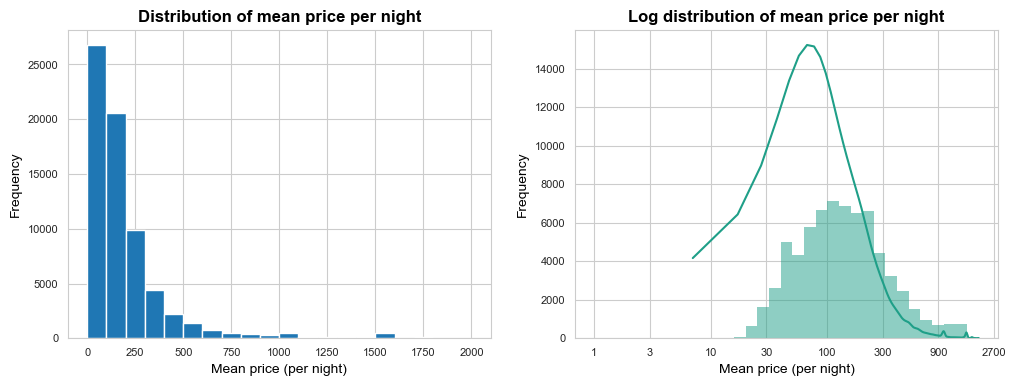

In [44]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
xbinsize = 100
xbins = np.arange(0, listing['price_mean'].max()+xbinsize, xbinsize)
plt.hist(data=listing, x='price_mean', bins=xbins)
plt.title('Distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')


plt.subplot(1,2,2)
log_binsize = 0.1
xbins = 10 ** np.arange(0, np.log10(listing['price_mean'].quantile(0.99))+log_binsize, log_binsize)
sns.histplot(data=listing, x='price_mean', bins=xbins, color=BASE_COLOR_SUB2, kde=True)
ticks = [1, 3, 10, 30, 100, 300, 900, 2700]
labels = ['{}'.format(tick) for tick in ticks]

plt.xscale('log')
plt.xticks(ticks,labels)

plt.title('Log distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.show()

>**Observation:**
>- Price is right skewed, yet normally distributed on a log scale with mean just over £100 

In [45]:
# save the enhanced flight file where outliers was removed, as pickle file to reuse during explanatory analysis
listing.to_pickle(FILE_NAME_ENHANCED)

### Summary of Univariate exploration

<blockquote>

During univariate exploration we can already answer the question, yes some hosts are running a business. We used entity recognition to introduce a new boolean feature 'is_business'. If the host name is a person's name we set the value to False. We investigated the distributions of mean daily price, minimum_nights and listings per hosts and cleaned up outliers.
    
**Most signifant findings:**
- Only 15% of listings have hosts living in the same neighborhood.
- 90% of listings have mininum nights set at 7 days or less, whilst 95% of listings have 14 days or less. Listings with minimum days > 14 days are rather exceptional.
- 90% of hosts have only 1 or 2 listings.
- +/- 3500 (5%) listings where detected where the host name was not a person's name, but rather a business like 'STK Homes'.
- Hosts with multiple listings are likely to be a business and mainly rent out entire homes or private rooms
- 99% of listings have prices <= £1,600 per night. Outliers beyond that were removed
   
**Transformations:**
- Hosts over inflate minimum number of nights and price per night to block a listing from being rented. As this is 'fake' data, outliers where removed where minimum nights exceeded 90 days and price exceeding £2000 per night.
                           
    
</blockquote>

<a id='bivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 2: Bivariate Exploration</span>


<blockquote>
During Univariate analysis, we observed some extremes in minimum nights, host listings and average price per night.

Let's further investigate these 3 features to detect their relationships with each other and other features of intests.
 
    
During bivariate exploration, we will focus on comparing features of interest for:
- miniumum nights above and below 30 days
- businesses vs individual listings   

</blockquote>

In [46]:
# clear the garbage to free memory
gc.collect()

27476

In [47]:
# reload the enhanced listings dataset
listing_enhanced = pd.read_pickle(FILE_NAME_ENHANCED)

In [48]:
# enhance columns of interest
try:
    cols_of_interest.remove('minimum_maximum_nights')
    cols_of_interest.append('is_business')
except ValueError:
    pass   

<span style="color:blue; font-size:16px; font-family: Calibri;">**Compare features where minimum nights are above and below 30 days. What is the impact on price and other features of interest?**</span>

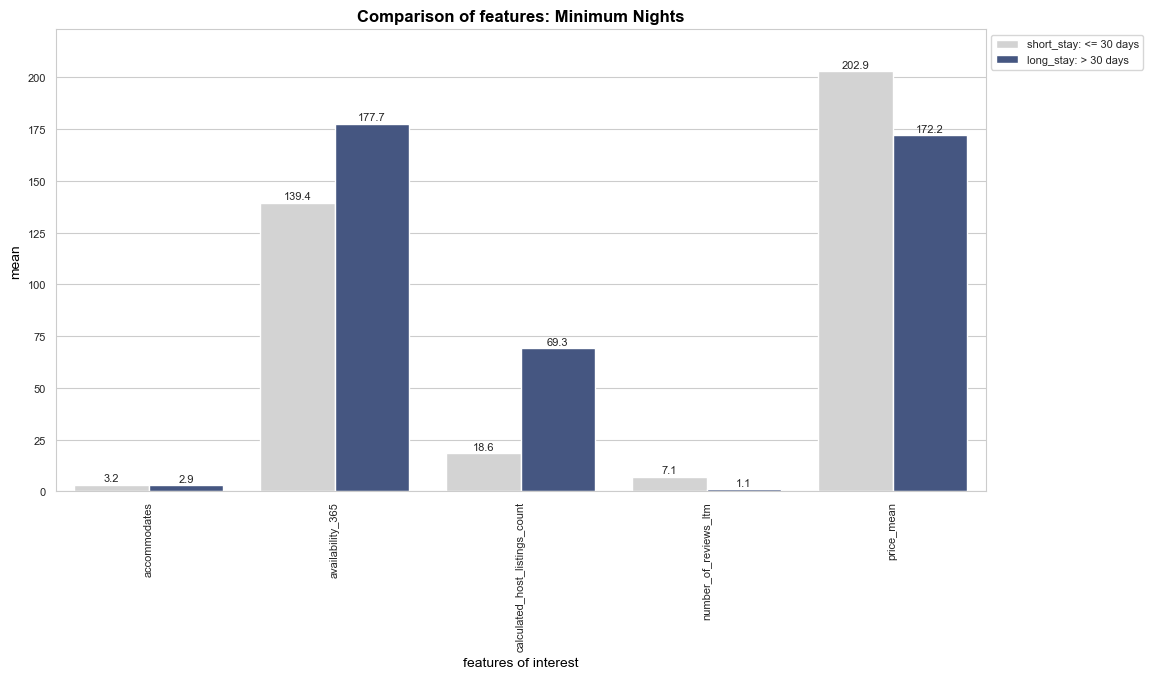

In [49]:
vs.compare_features(listing_enhanced, cols_of_interest.copy(), conda='minimum_minimum_nights <= 30', condb='minimum_minimum_nights > 30', cata_description='short_stay: <= 30 days', catb_description='long_stay: > 30 days', title_extension='Minimum Nights', feature_focus='minimum_minimum_nights')

>**Observation:**
>- Long stays over 30 days have slightly lower prices, have higher availability it's not as popular, and have less reviews in the last year. It occurs where hosts have multiple listings this is interesting.
>- Long stays are not connected to hosts running a business. Long stays occur more requently for individual hosts.
>- Features 'accommodates' and 'host_same_location' have little or no variation between the 2 groups

#### Let's dive deeper into the relationship between minimum nights and price

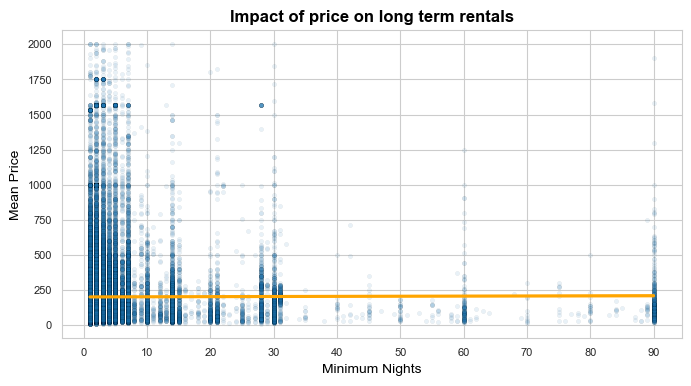

In [50]:
ticks = np.arange(0, int(listing_enhanced['minimum_minimum_nights'].max()+10), 10)

sns.regplot(data=listing_enhanced, x='minimum_minimum_nights', y='price_mean', fit_reg=True, truncate=True,
            scatter_kws={'alpha':0.1, 's':10, 'edgecolor':'black', 'linewidths':0.2}, line_kws={'color': 'orange'})

plt.xticks(ticks, ticks)
plt.title('Impact of price on long term rentals')
plt.xlabel('Minimum Nights')
plt.ylabel('Mean Price')
plt.show()

>**Observation:**
>- Just looking at the scatter plot, there is a downwards trend in price when minimum nights are up to 30 days, even if he regression line do not reflect that. Over 30 days looks a bit like noice, although we see intensity at monthly intervals at 60 and 90 days. 

In [51]:
#  Looks like minimum nights are condensed around 60 and 90 days, lets make weekly intervals instead
bin_edges = np.arange(0, 97, 7)
bin_labels = bin_edges[1:]
listing_enhanced['minimum_night_ranges'] = pd.cut(listing_enhanced['minimum_minimum_nights'], 
                                                  bins=bin_edges,
                                                  include_lowest=True,
                                                  labels=bin_labels).astype(int)

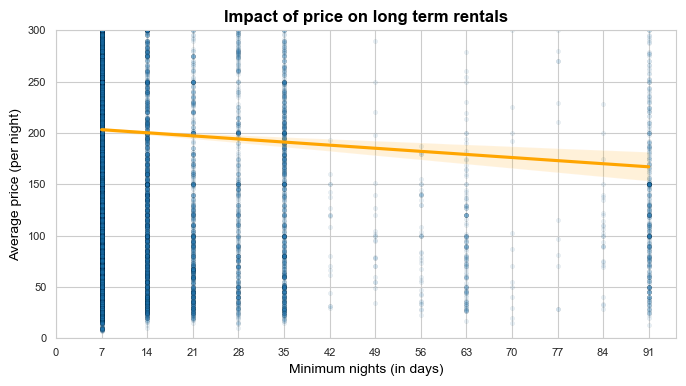

In [52]:
ticks = np.arange(0, int(listing_enhanced['minimum_night_ranges'].max()+7), 7)

sns.regplot(data=listing_enhanced, x='minimum_night_ranges', y='price_mean', fit_reg=True, truncate=True,
            scatter_kws={'alpha':0.1, 's':10, 'edgecolor':'black', 'linewidths':0.2}, line_kws={'color': 'orange'})

plt.xticks(ticks, ticks)
plt.xlabel('Minimum nights (in days)')
plt.ylabel('Average price (per night)')
plt.title('Impact of price on long term rentals')

plt.ylim(0, 300)

plt.show()

>**Observation:**
>- This looks better, we can now witness a slight decline in price when minimum nights increase in weekly buckets
>- It make sense that average price per night will come down for long term rentals, as hosts might give a discounted rate

<span style="color:blue; font-size:16px; font-family: Calibri;">**Some hosts run a business, what is the impact on price and other features ?**</span>

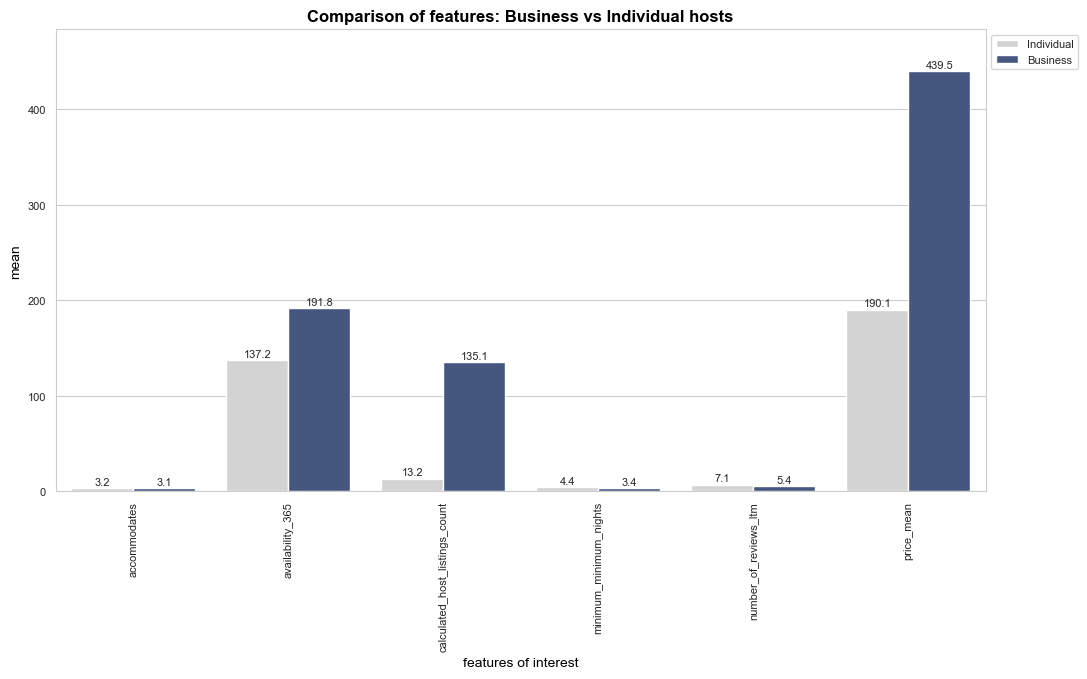

In [53]:
vs.compare_features(listing_enhanced, cols_of_interest.copy(), conda='is_business == False', condb='is_business == True', cata_description='Individual', catb_description='Business', 
                    title_extension='Business vs Individual hosts', feature_focus='is_business')

>**Observation:**
>- Businesses do charge significantly more for rentals with an average of £439, vs £190 by individuals
>- However my instict was wrong, bussiness do not focus on long term rentals, average minimum nights < 5 days
>- Businesses are more likely to allow instant_bookable
>- Number of listings per hosts are a clear indicator of hosts running a business
>- Businesses have higher availability possibily because price is higher

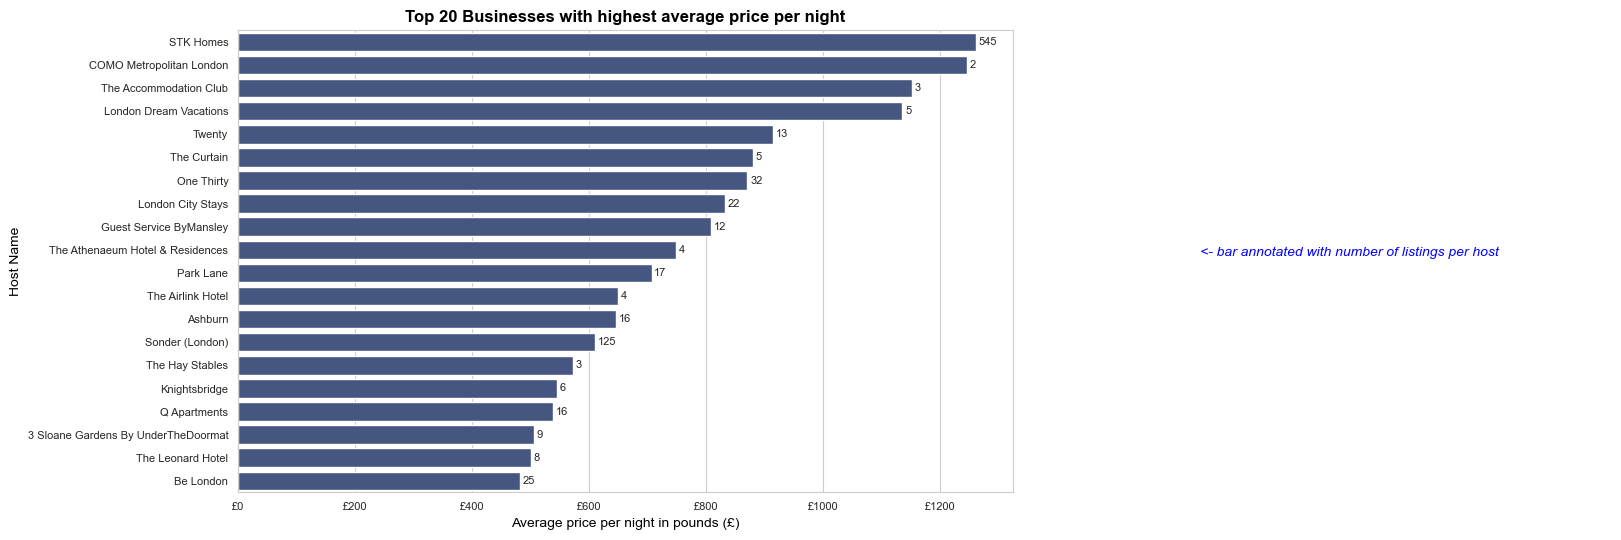

In [54]:
# Plot average price per business, is it really that expensive ?

plt.figure(figsize=(10,6))
f = {'price_mean':'mean', 'calculated_host_listings_count':'count'}
data = listing_enhanced[listing_enhanced['is_business'] == True].groupby('host_name').agg(f).sort_values(by='price_mean', ascending=False)[:20]

data.head()
ax1 = sns.barplot(data=data, y=data.index, x='price_mean', color=BASE_COLOR)

for container in ax1.containers:
    ax1.bar_label(container, labels=data['calculated_host_listings_count'], padding=2)

xticks = np.arange(0, 1400, 200)
xlabels = ['£{:1.0f}'.format(tick) for tick in xticks] 
plt.xticks(xticks, xlabels)
plt.xlabel('Average price per night in pounds (£)')

plt.title('Top 20 Businesses with highest average price per night')
plt.ylabel('Host Name')


# add footnote figure reference, as this plot will become the main reference for further analysis
footnote = "<- bar annotated with number of listings per host"
plt.text(s = footnote,
         x = 0.75,
         y = 0.71,
         fontname = 'Arial',
         fontstyle = 'italic',
         fontsize = 10,
         ha = 'left',
         color ='b',
         transform = fig.transFigure)

plt.show()

>**Observation:**
>- There are several businesses that have excessive prices, it's not only STK Homes

#### What is the relationship between number of listings and price ?

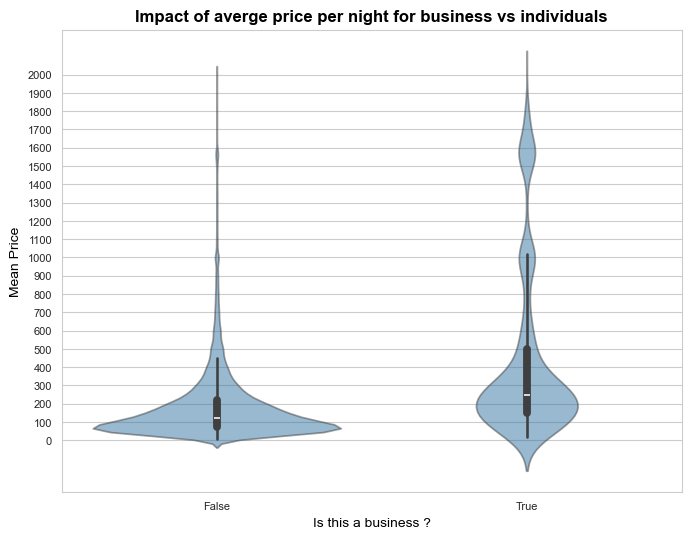

In [55]:
plt.figure(figsize=(8,6))
ticks = np.arange(0, int(listing_enhanced['price_mean'].max()+100), 100)
sns.violinplot(data=listing_enhanced, x='is_business', y='price_mean', alpha=0.5)
plt.yticks(ticks, ticks)
plt.title('Impact of averge price per night for business vs individuals')
plt.xlabel('Is this a business ?')
plt.ylabel('Mean Price')
plt.show()

>**Observation:**
>- Violin charts show very clearly the higher price distribution for businesses

#### Why are business rentals much more expensive, which type of properties are they renting out ?

In [56]:
# split dataset between business and individual
df_business = listing_enhanced[listing_enhanced['is_business'] == True]
df_individual = listing_enhanced[listing_enhanced['is_business'] == False]

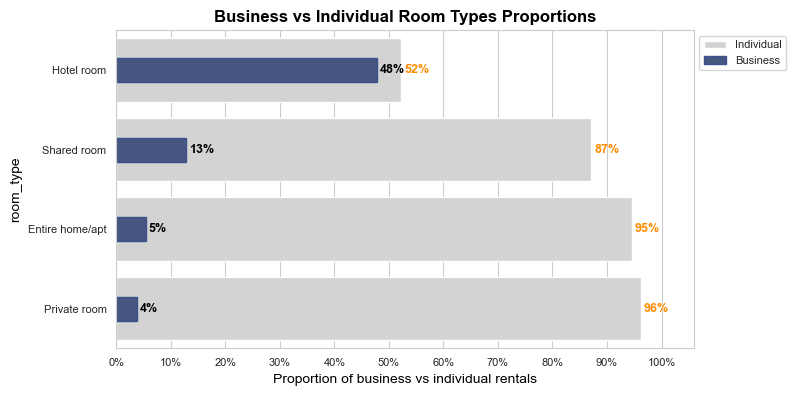

In [57]:
# plot distribution of business vs individual room type proportions
df = listing_enhanced.copy()
df['is_business'] = np.where(df['is_business'] == True, 'business', 'individual')
df = df.groupby('room_type')['is_business'].value_counts(normalize=True).unstack().sort_values(by='business', ascending=False)
df = df.reset_index()
df = df.set_index('room_type')
vs.plot_categories(df=df, title='Business vs Individual Room Types Proportions', topn=4, figsize=(8,4))

>**Observation:**
>- Even though business listings are a highly imbalanced portion of the dataset at only 5%, it has 48% of it's business in hotel rooms

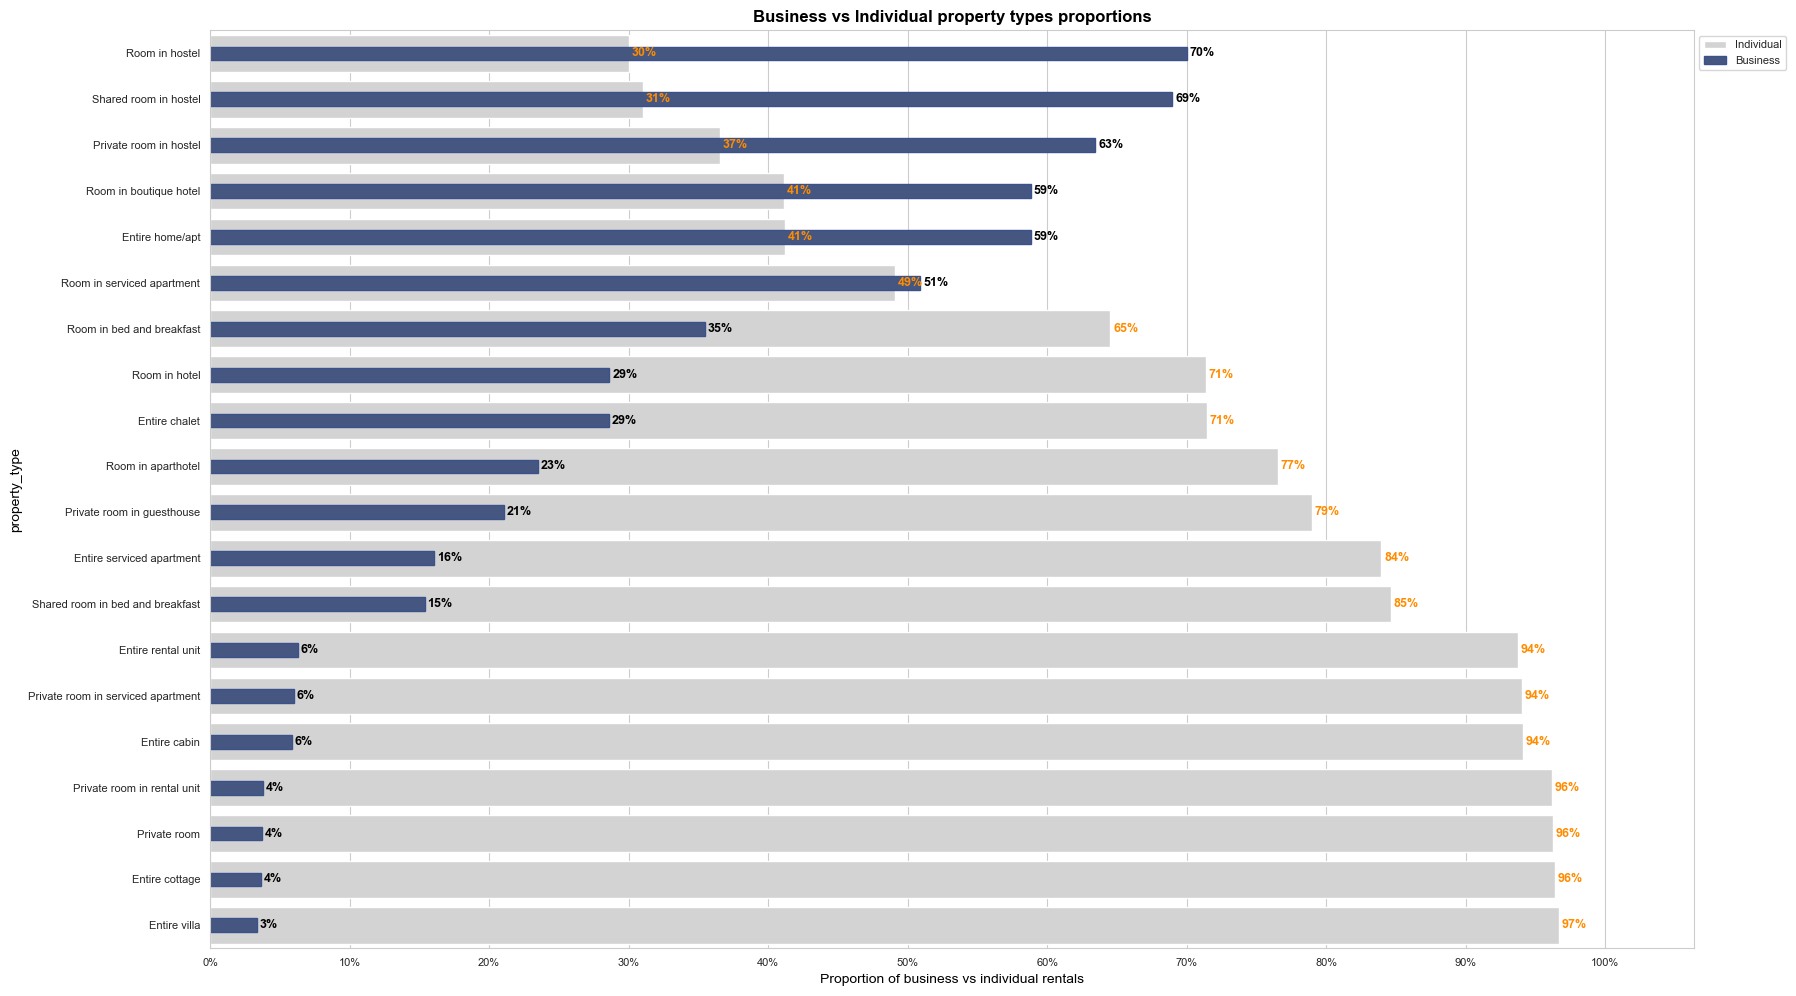

In [58]:
# plot distribution of business vs individual property tipe proportions
df = listing_enhanced.copy()
df = df[df['property_type'] != 'Private room in religious building']
df['is_business'] = np.where(df['is_business'] == True, 'business', 'individual')
df = df.groupby('property_type')['is_business'].value_counts(normalize=True).unstack().sort_values(by='business', ascending=False)
df = df.reset_index()
df = df.set_index('property_type')
vs.plot_categories(df=df, title='Business vs Individual property types proportions', topn=20)

>**Observation:**
>- Hostel accommodations appear to have high proportions in business rentals, that is quite strange
>- Hotel, bed-and-breakfast, serviced apartment and entire places make up big proportions of business rentals

Businesses seems to target higher luxury in the same property type category, a hostel is not just a hostel !

<img src="../images/hostel_quality.png" alt="drawing" width="900" align="left"/>

### Summary of Bivariate exploration

<blockquote>

After bivariate exploration we now understand the characteristics of long term and business rentals.
   
**Most signifant findings:**

>- Number of listings per hosts are a clear indicator of hosts running a business
>- Businesses do charge significantly more for rentals with an average of £439, vs £190 by individuals
>- Businesses have higher availability possibily because price is higher
>- Businesses focus on more on upper market listings and give their hosts privacy with private rooms or entire properties, which could explain the higher price bracket. Sharing living spaces are not common.  
>- Businesses are more likely to allow instant_bookable   
>- However my initial instict was wrong, bussiness do not focus on long term rentals, average minimum nights < 5 days
>- Average price per night becomes cheaper for long term rentals, as hosts might give a discounted rate                                                                                                                
    
</blockquote>

<a id='multivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 3: Multivariate Exploration</span>

We know that businesses charge higher prices on average per night. Let's further explore which kind of properties have these high prices.

Let's deeper explore correlations and relationships between features for business vs individuals 

<span style="color:blue; font-size:16px; font-family: Calibri;">**Lets get a quick overview of relationships between numerical features of interest**</span>

In [59]:
cols = cols_of_interest.copy()
try:
    cols.remove('is_business')
#     cols.append('number_of_reviews')    
except ValueError:
    pass       

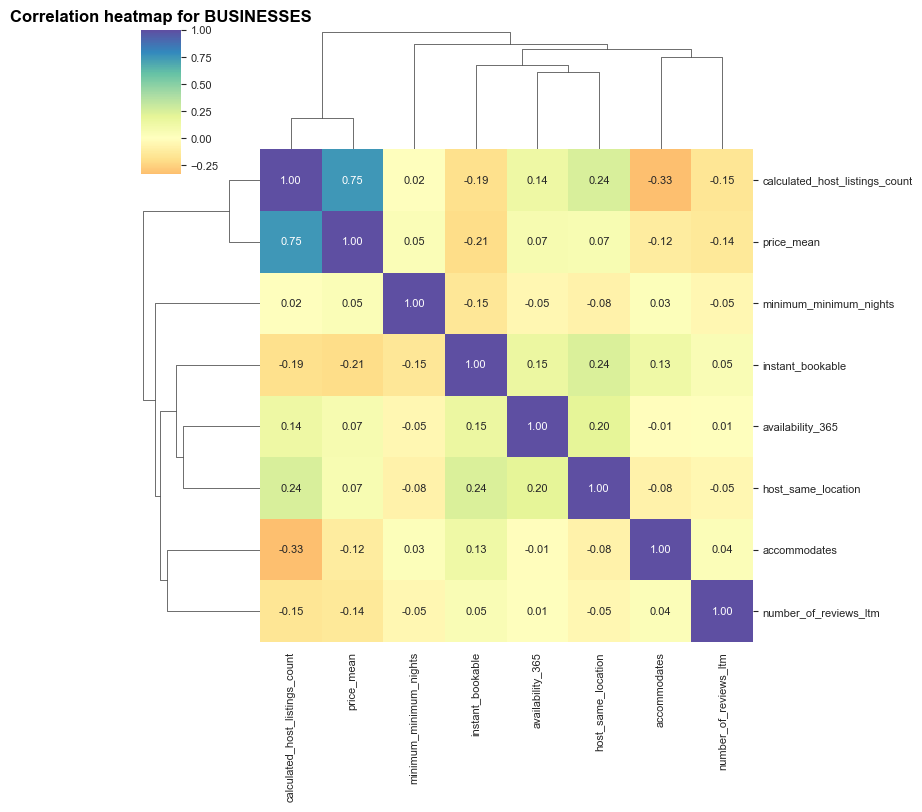

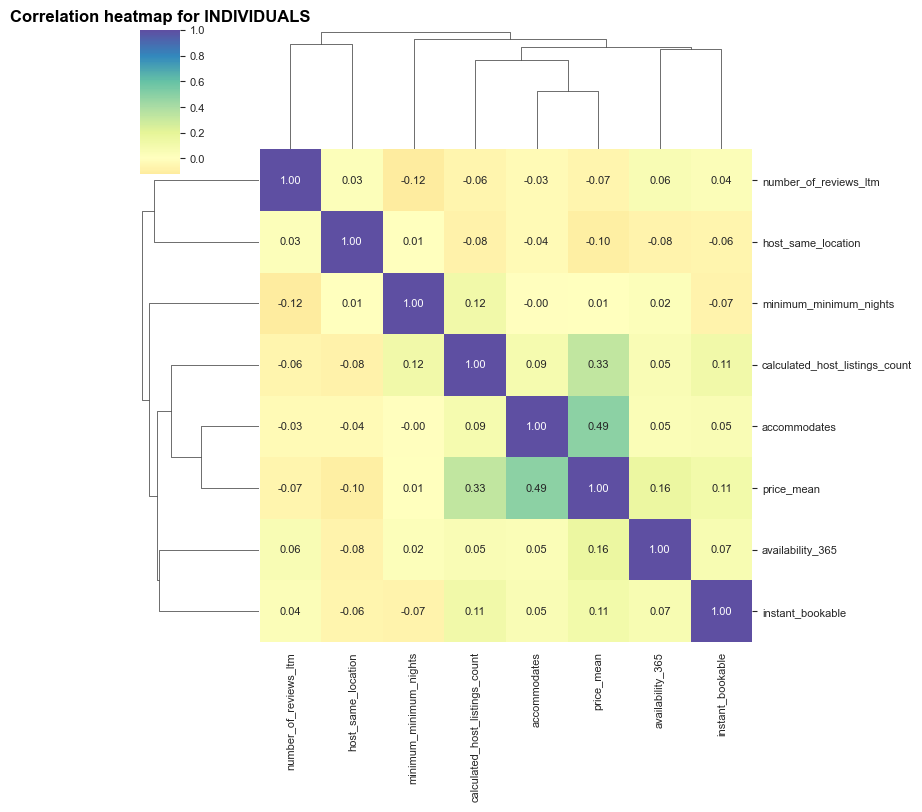

In [60]:
ax1 = sns.clustermap(df_business[cols].corr(), cmap="Spectral", center=0, annot=True, fmt='.2f', figsize=(8,8))
plt.title('Correlation heatmap for BUSINESSES')

ax2 = sns.clustermap(df_individual[cols].corr(), cmap="Spectral", center=0, annot=True, fmt='.2f', figsize=(8,8))
plt.title('Correlation heatmap for INDIVIDUALS')

plt.show()

# reset default plot formatting back
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

#### Observation:

<blockquote>


-    The strongest correlation are between mean price and number of listings. Prices are higher for hosts with multiple listings, especially for businesses, which we saw this already during bivariate analysis.   

-    Its weird that correlation between **accommodates and number of listings and price is negative** for businesses, whilst for individuals this correlation is not strong at all. Are businesses renting smaller 2-person accommodation like hotel rooms whilst individuals targer bigger groups ? 
    
##### Businesses:    
    
- As number of listings increase:
    - host in same location incease - when it's a huge apartment block, maybe the host is present looking after the building?
    - There is a positive correlation between host in the same location and instant bookable
    
    
##### Individuals:
  
- The stongest correlations are between accommodation and price. Price goes up of occupants in a property goes up, this make sense
    
</blockquote>

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_33115/2176677608.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg._legend.legendHandles:


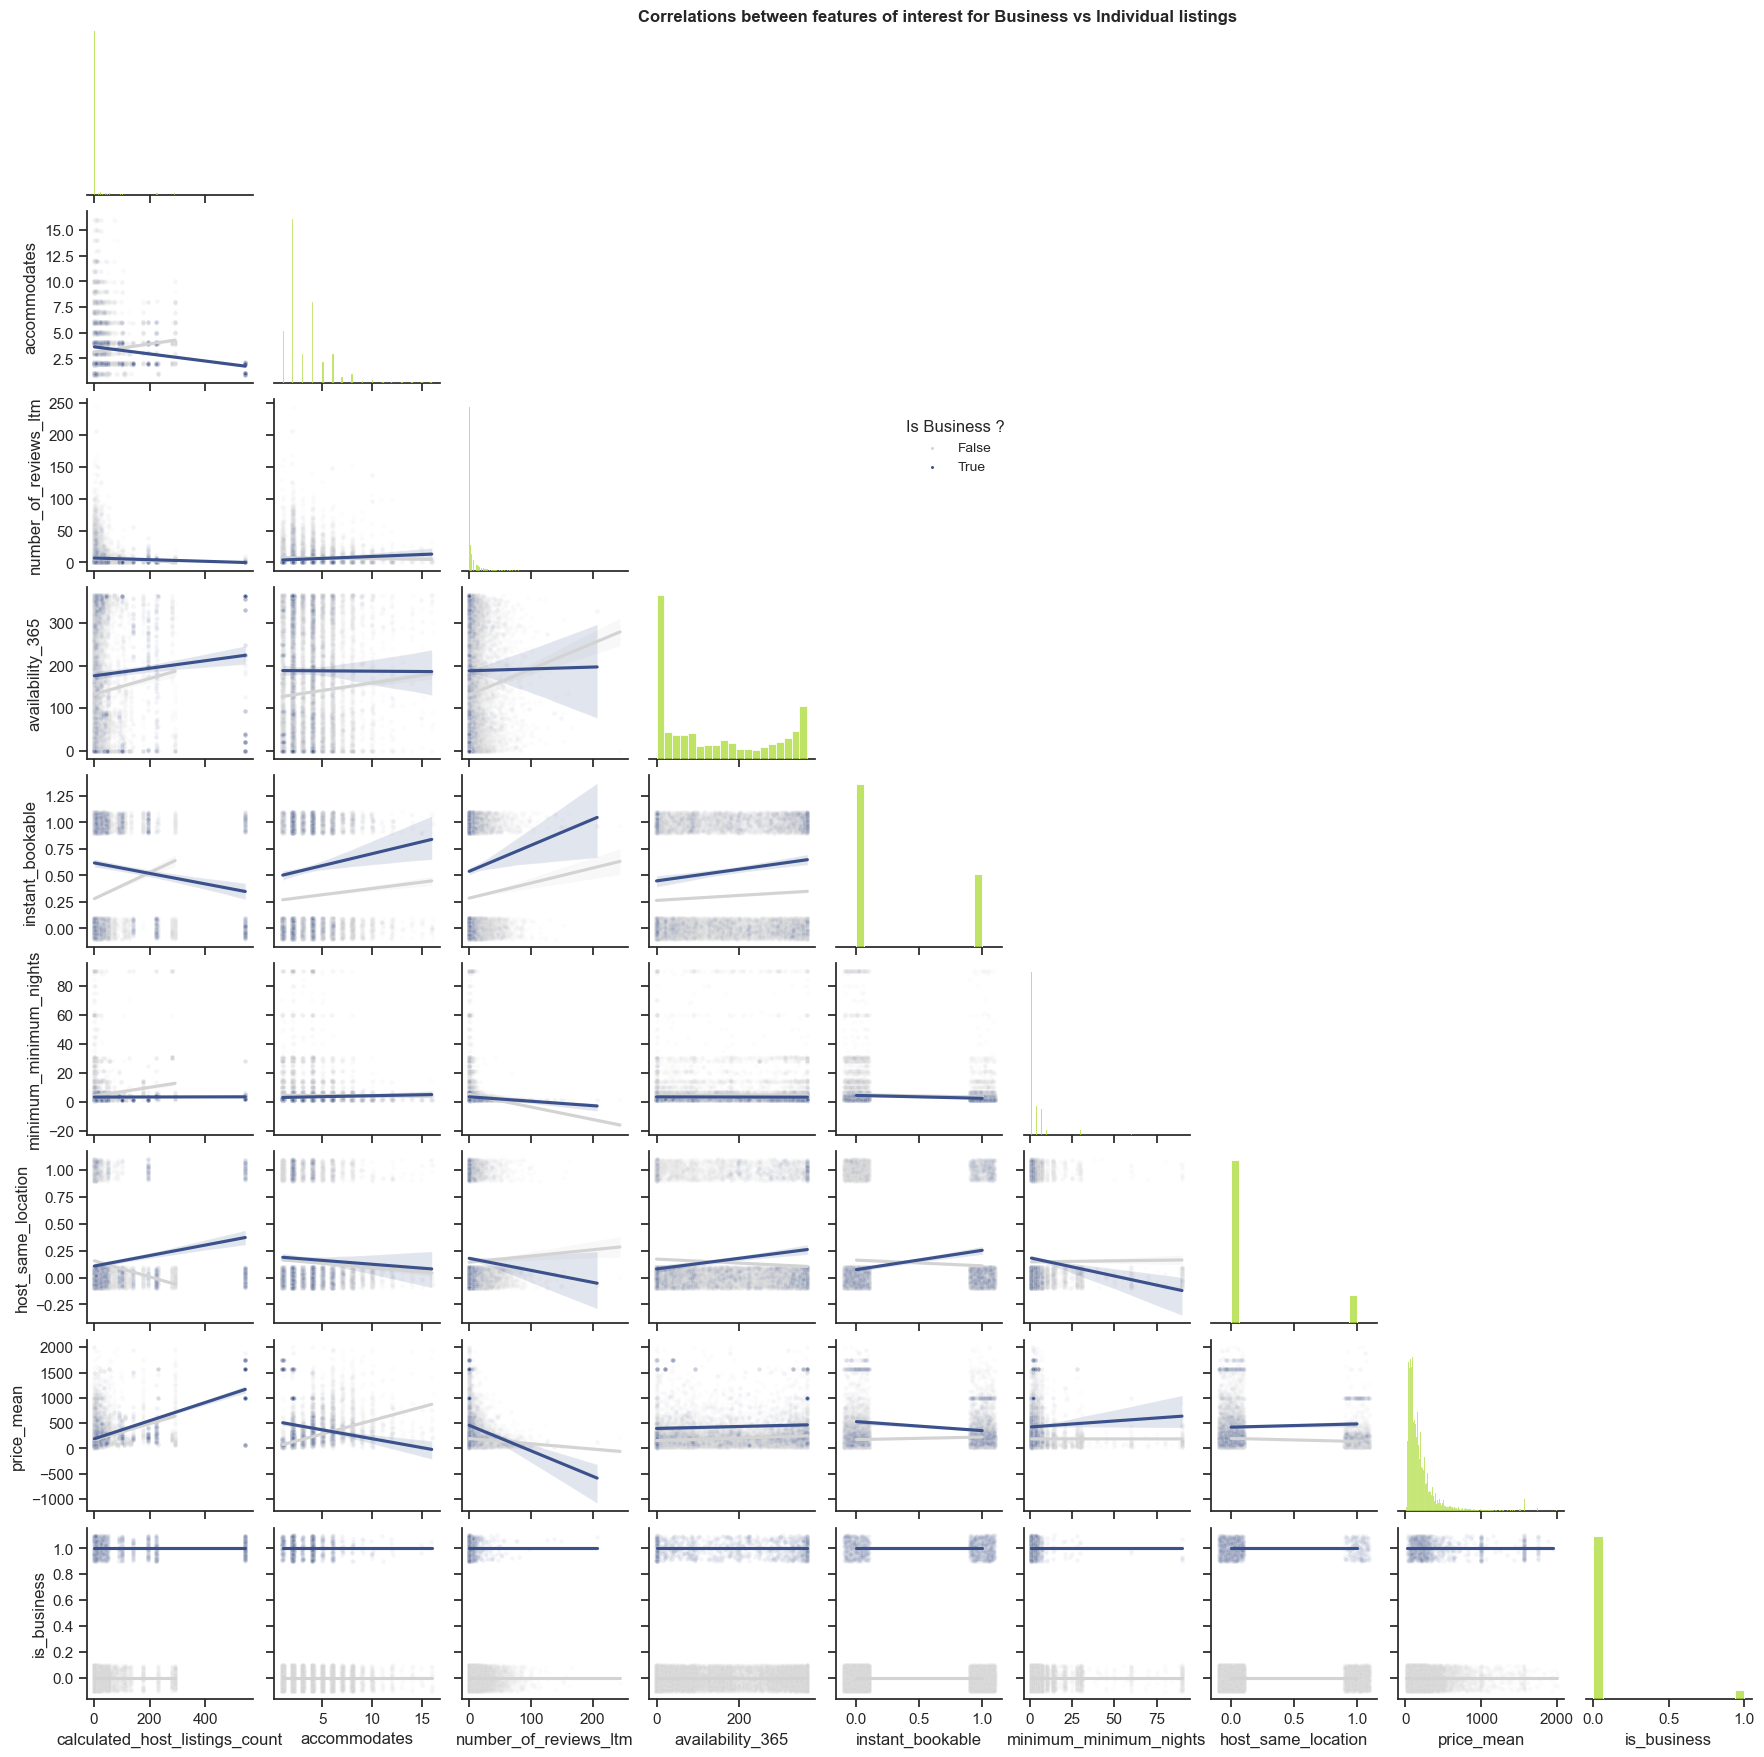

In [61]:
# Correlation analysis

# take a sample of listings to speed of performance for regplot relationship
sample = np.random.choice(listing_enhanced.shape[0], 20000, replace=False)
listing_sample = listing_enhanced.iloc[sample].copy()

listing_sample = listing_sample[cols_of_interest].copy()
listing_sample.fillna(0, inplace=True)

# # handle logscale
# for col in cols_of_interest:
#     listing_sample[col] = np.where(listing_sample[col] == 0, 0.9, listing_sample[col])

sns.set(style='ticks')
# g = sns.PairGrid(data=listing_sample, vars=cols_of_interest, corner=True, dropna=True, diag_sharey=False, despine=True, height=2, aspect=1, hue='is_business', palette={True: BASE_COLOR, False: BASE_COMPLEMENTRY},)
g = sns.PairGrid(data=listing_sample, vars=cols_of_interest, corner=True, dropna=True, diag_sharey=False, despine=True, height=2, aspect=1, hue='is_business', palette={True: BASE_COLOR, False: BASE_GREY},)
g.map_diag(sns.histplot, color=BASE_HIGHLIGHT, hue=None, palette=None)
g.map_offdiag(sns.regplot, fit_reg=True, y_jitter=0.1, x_jitter=0.1, truncate=True, scatter_kws={'s':10, 'edgecolor':'white', 'alpha':0.05})
    
plt.suptitle('Correlations between features of interest for Business vs Individual listings')
leg = g.add_legend(title='Is Business ?', fontsize='small', title_fontsize='large', loc='upper center')  
g._legend.set_bbox_to_anchor((0.5, 0.75))

# set legend alpha to be clear again
for handle in leg._legend.legendHandles: 
    handle.set_alpha(1)
g.tight_layout()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

<blockquote>

**Observations**:
    
- Accommodates have different behavior for business vs individual. For business, price goes down when occupants goes up, whilst for individual price does up when accommodates go up
- When price goes up for businesses, number of reviews gets less at a steaper rate as for individuals
- for business, instant bookable does down when price goes up

Businesses:
 
- Accommodates less people
- Have fewer reviews
- Have less availability
- Have shorter periods for minimum nights
    
</blockquote>

<span style="color:blue; font-size:16px; font-family: Calibri;">**Lets compare prices between room property types for individual vs business. Which properties cause price hikes?**</span>

In [62]:
# first, lets understand relationship between room_type and property_type
listing_enhanced[['room_type', 'property_type']].drop_duplicates().sort_values(['room_type', 'property_type'])

,room_type,property_type
12259,Entire home/apt,Barn
1768,Entire home/apt,Boat
3842,Entire home/apt,Camper/RV
17547,Entire home/apt,Campsite
27175,Entire home/apt,Casa particular
42318,Entire home/apt,Castle
29074,Entire home/apt,Dome
7797,Entire home/apt,Earthen home
2968,Entire home/apt,Entire bungalow
642,Entire home/apt,Entire cabin


>**Observation:**
> - Looking at just the room type can be very misleading, as it's sub catogory can be anything from an entire home or apartment to a tent or caravan, there is big difference in quality and I image price range

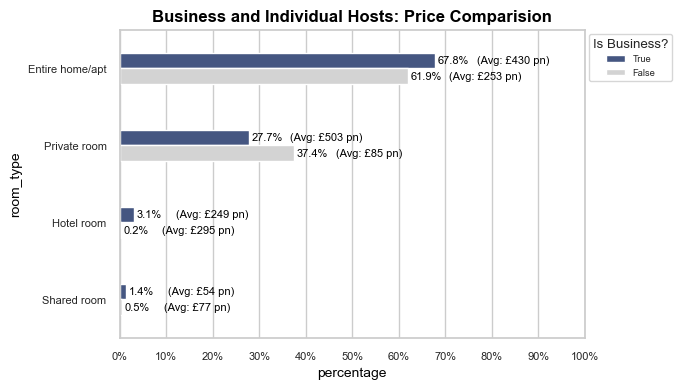

In [63]:
# compare room types
vs.annotate_grouped_barplot(df_business, df_individual, hue='is_business', x='room_type', y='percentage', figsize=(6,4), legend_title='Is Business?')

>**Observation:**
> - Average prices for a business listing are much higher for entire homes/apartments or private rooms. For Hotel rooms and shared rooms, the prices are closer together.
> - The room type proportion split are roughly the same for business vs individual listings individually

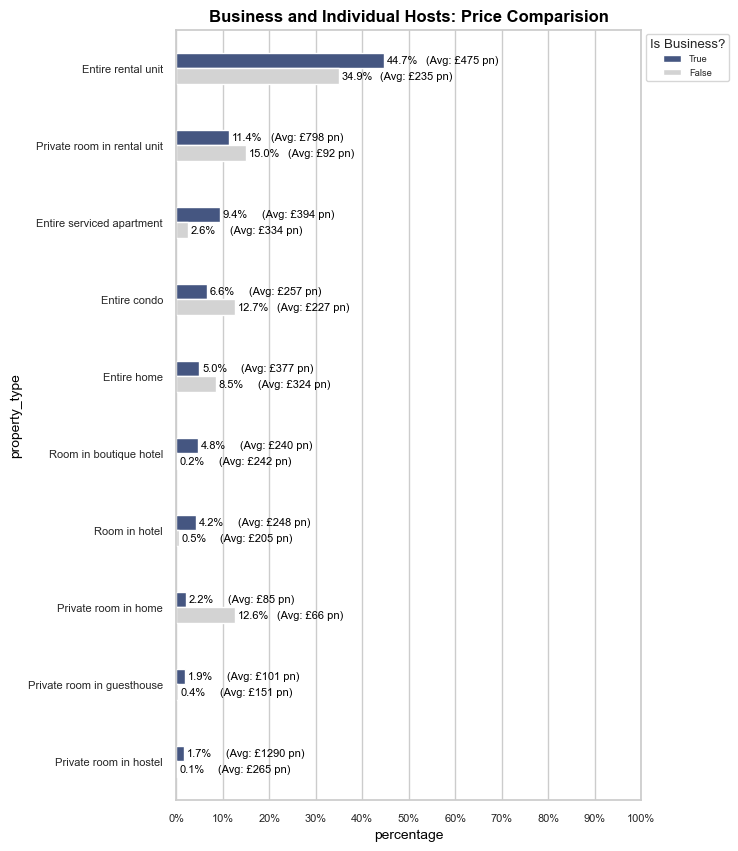

In [64]:
# compare property types
vs.annotate_grouped_barplot(df_business, df_individual, hue='is_business', x='property_type', y='percentage', legend_title='Is Business?')

>**Observation:**
> - Average prices for a business listing are significantly higher for categories **'Entire rental unit'**, **'Private room in rental unit'** and **'Private room in a hostel'**. These 3 categories make up 65% of business listing's rentals and highlight the key difference between business and individual listings

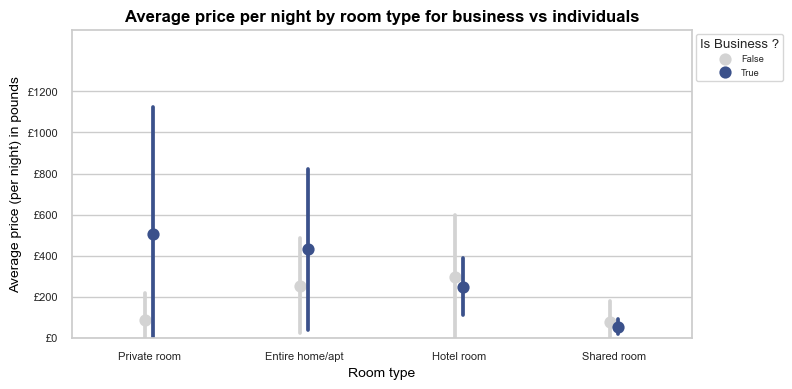

In [65]:
plt.figure(figsize=(8,4))
g = sns.pointplot(data=listing_enhanced, x='room_type', y='price_mean', hue='is_business', dodge=True, palette={True: BASE_COLOR, False: BASE_GREY}, 
                  errorbar='sd', linestyles="", marker='o')
plt.title('Average price per night by room type for business vs individuals')
plt.ylabel('Average price (per night) in pounds')
plt.xlabel('Room type')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Is Business ?', fontsize='small', title_fontsize='large')

plt.ylim(0, 1500)
yticks = np.arange(0, 1400, 200)
ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
plt.yticks(yticks, ylabels)

plt.show()

>**Observation:**
> - Business listings for 'Private room' and 'Entire home/apt' are higher than individual listings, and have a wide price range with lots of variability.

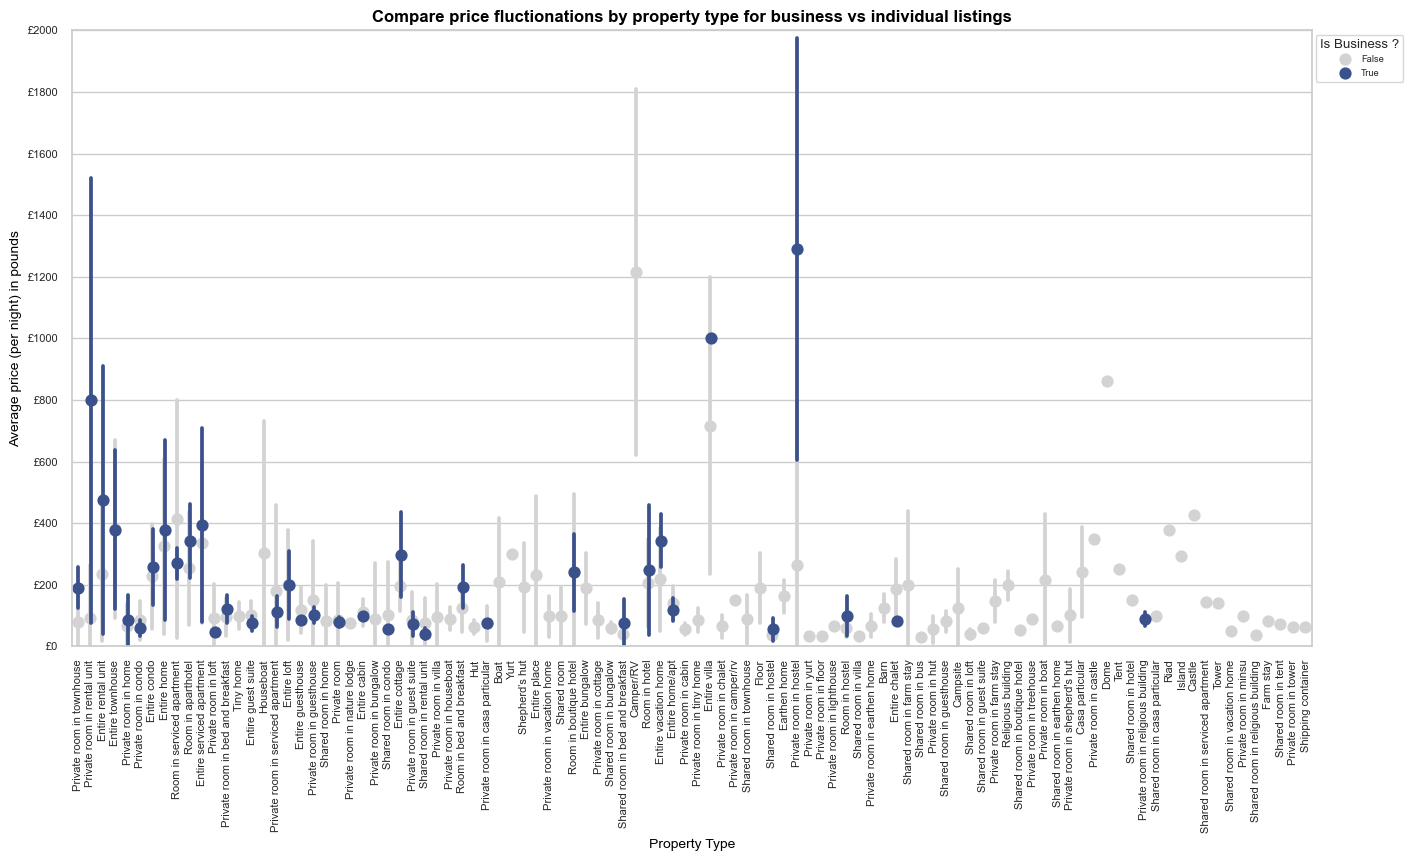

In [66]:
plt.figure(figsize=(16,8))
ax = sns.pointplot(data=listing_enhanced, x='property_type', y='price_mean', hue='is_business', dodge=True, palette={True: BASE_COLOR, False: BASE_GREY},
              errorbar='sd', linestyles="", marker='o')

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Is Business ?', fontsize='small', title_fontsize='large')
plt.title('Compare price fluctionations by property type for business vs individual listings')
plt.xlabel('Property Type')
plt.ylabel('Average price (per night) in pounds')

yticks = np.arange(0, 2200, 200)
ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
plt.yticks(yticks, ylabels)

plt.ylim(0, 2000)

plt.show()

>**Observation:**
> - Private rooms on the left of the graph, are dominated by high business listing prices in blue with again big variability in price
> - Shared rooms on the right of the graph, are dominated by individial listings in grey, lower prices around £100 with not a lot of variability
>- 'Private room in hostel' stands out in the middel of the graph, business have significant higher prices, whilst both business and individual listings show very high variability in price. Looks like a massive outlier
>- Camper/RV' in the middel of the graph dominated by individuals in grey, have high prices with lots of variability. This is a watch-out for price predictions in last step of the project

<span style="color:blue; font-size:16px; font-family: Calibri;">**Explore unusual relationship between accommodation and price we have seen during correlation analysis**</span>

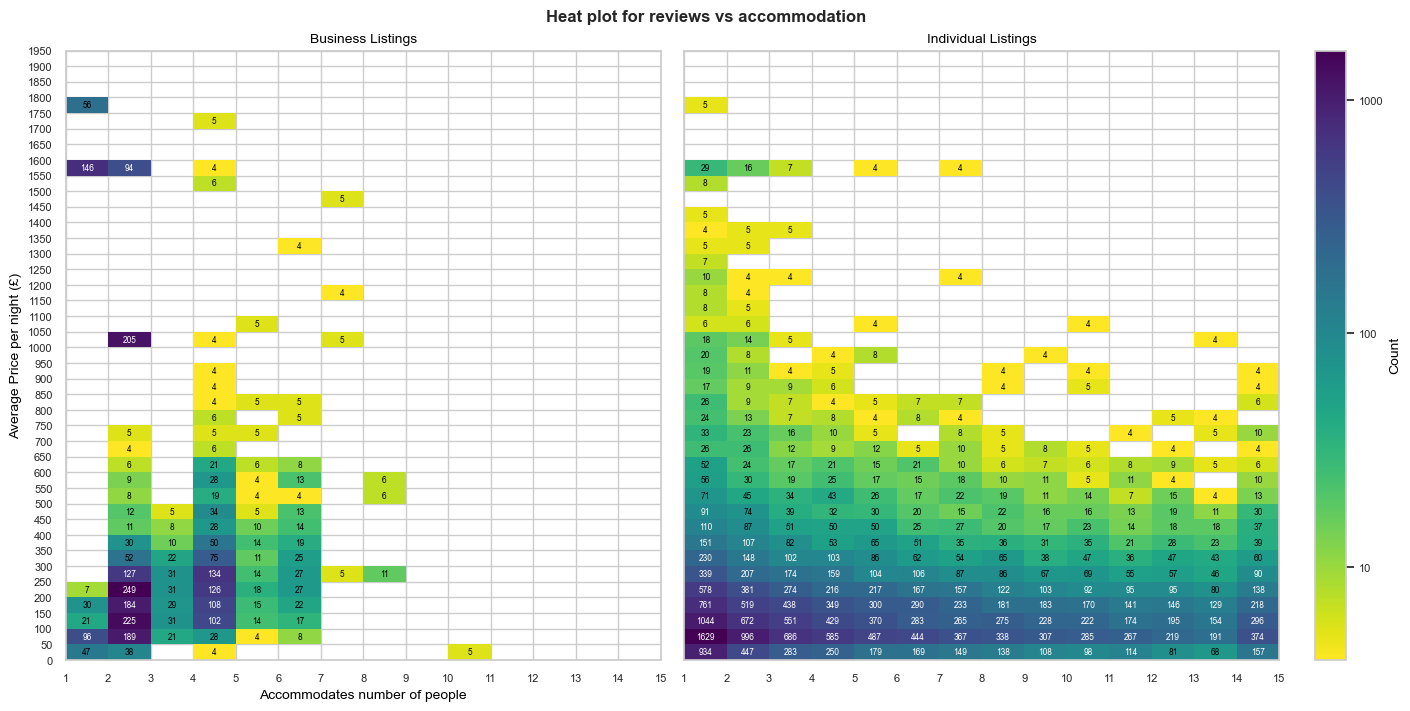

In [67]:
from matplotlib.colors import LogNorm
from matplotlib import ticker

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), squeeze=True, sharex=True, sharey=True, tight_layout=True, layout='constrained')

xbins = np.arange(1, df_individual['accommodates'].max(), 1)
ybins = np.arange(0, df_individual['price_mean'].max(), 50)

xticks = np.arange(1, df_individual['accommodates'].max(), 1)
yticks = np.arange(0, df_individual['price_mean'].max(), 50)

# define normalization of the colors
h1 = ax1.hist2d(data=df_business, x='accommodates', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=4), cmin=4)
ax1.set_xticks(xticks, xticks)
ax1.set_yticks(yticks, yticks)

ax1.set_xlabel('Accommodates number of people')
ax1.set_ylabel('Average Price per night (£)')
ax1.set_title('Business Listings', weight='light', fontsize=10)
ax1.set_xlim(0,1000)

h2 = ax2.hist2d(data=df_individual, x='number_of_reviews', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=4), cmin=4)

ax2.set_title('Individual Listings', weight='light', fontsize=10)
ax1.set_xlabel('Accommodates number of people')
ax1.set_ylabel('Average Price per night (£)')

cb2 = fig.colorbar(h2[3], ax=ax2, orientation='vertical', ticks=None)
cb2.set_label('Count', fontsize=10)
cb2.ax.yaxis.set_major_formatter(ticker.ScalarFormatter()) # remove the scientific notation
cb2.ax.yaxis.set_minor_locator(ticker.NullLocator()) # optionally remove the minor ticks


# Add text annotation for plot 1
# Loop through the cell counts and add text annotations for each
counts = h1[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 90: # increase visibility on darker cells
            ax1.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax1.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)
            
# Add text annotation for plot 2            
counts = h2[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 90: # increase visibility on darker cells
            ax2.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax2.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)            

plt.suptitle('Heat plot for reviews vs accommodation')

plt.show()

>**Observation:**
>- Businesses accommodates mainly up to 6 people, and have very high prices jumping out above £1000 for 2 people. Price goes up when accommodates go down. This might indicates luxury romatic breaks for two ?
>- Individuals accommodates larger groups up to 15 people. We can observe a downwards trent, price comes down accommodates goes down

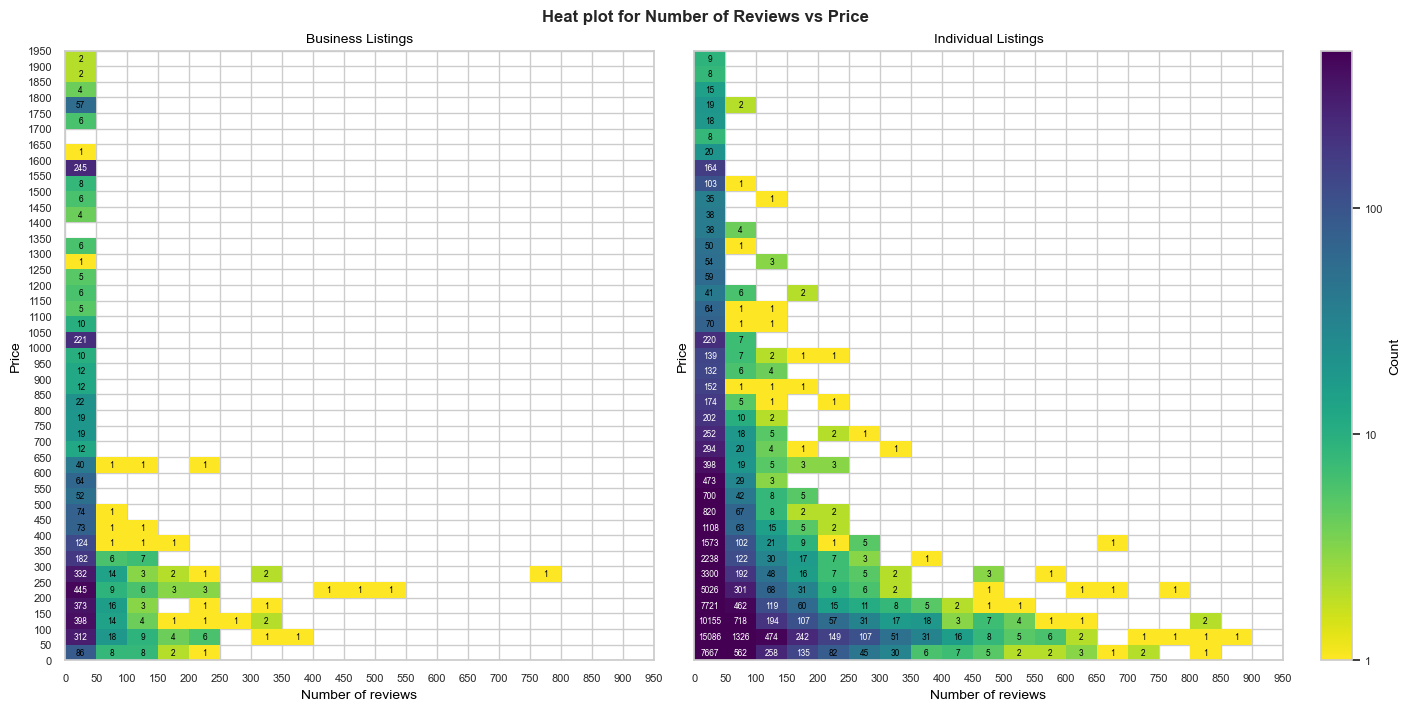

In [68]:
from matplotlib.colors import LogNorm
from matplotlib import ticker

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), squeeze=True, sharex=True, sharey=True, tight_layout=True, layout='constrained')

xbins = np.arange(0, 1000, 50)
ybins = np.arange(0, df_individual['price_mean'].max(), 50)

xticks = np.arange(0, 1000, 50)
yticks = np.arange(0, df_individual['price_mean'].max(), 50)

# define normalization of the colors
h1 = ax1.hist2d(data=df_business, x='number_of_reviews', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=1, vmax=500), cmin=0.5)
ax1.set_xticks(xticks, xticks)
ax1.set_yticks(yticks, yticks)

ax1.set_xlabel('Number of reviews')
ax1.set_ylabel('Price')
ax1.set_title('Business Listings', weight='light', fontsize=10)
ax1.set_xlim(0,1000)

h2 = ax2.hist2d(data=df_individual, x='number_of_reviews', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=1, vmax=500), cmin=0.5)

ax2.set_title('Individual Listings', weight='light', fontsize=10)
ax2.set_xlabel('Number of reviews')
ax2.set_ylabel('Price')



cb2 = fig.colorbar(h2[3], ax=ax2, orientation='vertical', ticks=None)
cb2.set_label('Count', fontsize=10)
cb2.ax.yaxis.set_major_formatter(ticker.ScalarFormatter()) # remove the scientific notation
cb2.ax.yaxis.set_minor_locator(ticker.NullLocator()) # optionally remove the minor ticks


# Add text annotation for plot 1
# Loop through the cell counts and add text annotations for each
counts = h1[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darker cells
            ax1.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax1.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)
            
# Add text annotation for plot 2            
counts = h2[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darker cells
            ax2.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax2.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)            

plt.suptitle('Heat plot for Number of Reviews vs Price')

plt.show()

>**Observation:**
> - Individuals have a lot more reviews that businesses. There is a clear pattern, as price decrease reviews increase

In [69]:
# save the enhanced flight file where outliers was removed, as pickle file to reuse during explanatory analysis
listing_enhanced.to_pickle(FILE_NAME_ENHANCED)

<a id='conclusions'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Conclusions</span>





<blockquote>

**Appoach:**
    
   
    
- From univariate exploration, we know that the number of listings per host and minimum nights per rental are the 2 strongest indicators to **detect hosts that are running a business**. In addition I used AI entity recognition from the STANZA package to flag the host name as either a person or business name.
    
- In bivariate exploration, we attempt to understand the **behavioral differences** between business and individual rentals. I zoomed into the relationships between key features of interest for businesses and indivuals irrespectively to detect **differences in correlations** between the 2 groups.    
    
- In bivariate exploration, I explored the relationships of minimum nights and business vs individuals listings with other features of interest. Which features differenciate these two groups ? We also looked at the proportional differences in room and property types for business vs individuals rentals to understand which kind of properties each group focus on.

- In multivariate exploration, we attempt to understand deeper the **behavioral differences** between business and individual rentals. I zoomed into the relationships between key features of interest for businesses and indivuals irrespectively to detect **differences in correlations** between the 2 groups. I explored factors which could cause high price variations we should be aware of when trying to predict price in the last step of this project. 

A divergent palette vidiris_r was used consistently, where yellow/light green is used to show low correlation, and dark green/blue to show above average correlations.

**Main findings:**
    

- Number of listings per hosts are a clear indicator of hosts running a business
- Businesses do charge significantly more for rentals with an average of £439, vs £190 by individuals
- Businesses have higher availability possibily because price is highe
- Businesses focus on more on upper market listings and give their hosts privacy with private rooms or entire properties, which could explain the higher price bracket. Sharing living spaces are not common.  
- Businesses are more likely to allow instant_bookable   
- However my initial instict was wrong, bussiness do not focus on long term rentals, average minimum nights < 5 days
- Average price per night becomes cheaper for long term rentals, as hosts might give a discounted rate   
    

    
</blockquote>

<a id='references'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">References</span>

- [white text in pie chart](https://www.tutorialspoint.com/how-to-change-autopct-text-color-to-be-white-in-a-pie-chart-in-matplotlib)
- [interpretting acf and pacf graphs](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
- [formating xaxis date labels](https://stackoverflow.com/questions/56638648/seaborn-barplot-and-formatting-dates-on-x-axis)
- [annotate barplot](https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/)
- [annoate barplot vertical vs horizontal](https://www.kaggle.com/code/asimislam/tutorial-annotate-placing-numbers-on-plots)
- [annotate plot with mean value](https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib)
- [A Little Bit Of Extra Effort Can Hugely Transform Your Basic Matplotlib Plots](https://github.com/ChawlaAvi/Daily-Dose-of-Data-Science/blob/main/Plotting/Professional-Plots-With-Matplotlib.ipynb?utm_source=substack&utm_medium=email)
- [Using NLTP](https://stanfordnlp.github.io/stanza/#getting-started)
- [Annotate grouped bars](https://stackoverflow.com/questions/73491317/how-to-annotate-grouped-bars-with-the-value-and-text-from-a-different-column)
- [hostel business listing taken from](https://www.airbnb.co.uk/rooms/26316886?_set_bev_on_new_domain=1697737032_ZTdhMDk1N2E5MjFh&source_impression_id=p3_1697737032_JIntvD2jJ5%2FBIoXv&check_in=2023-10-26&guests=1&adults=1&check_out=2023-10-28)
- [hostal private listing image taken from](https://www.airbnb.co.uk/rooms/17584230?_set_bev_on_new_domain=1697737032_ZTdhMDk1N2E5MjFh&source_impression_id=p3_1697800369_mfX%2Bxf%2BVlBNMb%2Fs5)
- [set legend symbol opacity](https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity)

>**Observation:**
> - Private rooms on the left of the graph, are dominated by high business listing prices in orange with again big variability in price
> - Shared rooms on the right of the graph, are dominated by individial listings, lower prices around £100 with not a lot of variability
>- 'Private room in hostel' stands out in the middel of the grap, business have significant higher prices, whilst both business and individual listings show very high variability in price|

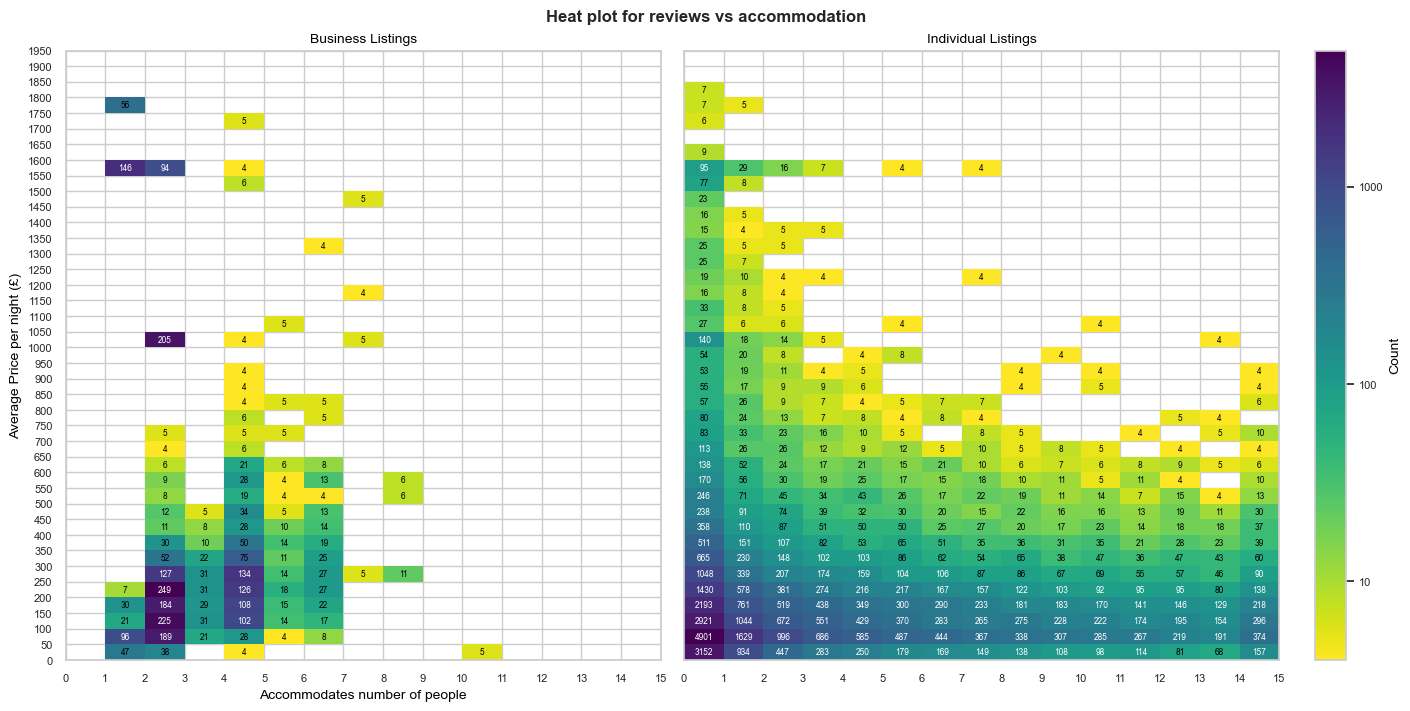

In [70]:
from matplotlib.colors import LogNorm
from matplotlib import ticker

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), squeeze=True, sharex=True, sharey=True, tight_layout=True, layout='constrained')

xbins = np.arange(0, df_individual['accommodates'].max(), 1)
ybins = np.arange(0, df_individual['price_mean'].max(), 50)

xticks = np.arange(0, df_individual['accommodates'].max(), 1)
yticks = np.arange(0, df_individual['price_mean'].max(), 50)

# define normalization of the colors
h1 = ax1.hist2d(data=df_business, x='accommodates', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=4), cmin=4)
ax1.set_xticks(xticks, xticks)
ax1.set_yticks(yticks, yticks)

ax1.set_xlabel('Accommodates number of people')
ax1.set_ylabel('Average Price per night (£)')
ax1.set_title('Business Listings', weight='light', fontsize=10)
ax1.set_xlim(0,1000)

h2 = ax2.hist2d(data=df_individual, x='number_of_reviews', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=4), cmin=4)

ax2.set_title('Individual Listings', weight='light', fontsize=10)
ax1.set_xlabel('Accommodates number of people')
ax1.set_ylabel('Average Price per night (£)')



cb2 = fig.colorbar(h2[3], ax=ax2, orientation='vertical', ticks=None)
cb2.set_label('Count', fontsize=10)
cb2.ax.yaxis.set_major_formatter(ticker.ScalarFormatter()) # remove the scientific notation
cb2.ax.yaxis.set_minor_locator(ticker.NullLocator()) # optionally remove the minor ticks


# Add text annotation for plot 1
# Loop through the cell counts and add text annotations for each
counts = h1[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 90: # increase visibility on darker cells
            ax1.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax1.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)
            
# Add text annotation for plot 2            
counts = h2[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 90: # increase visibility on darker cells
            ax2.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax2.text(xbins[i]+0.5, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)            

plt.suptitle('Heat plot for reviews vs accommodation')

plt.show()

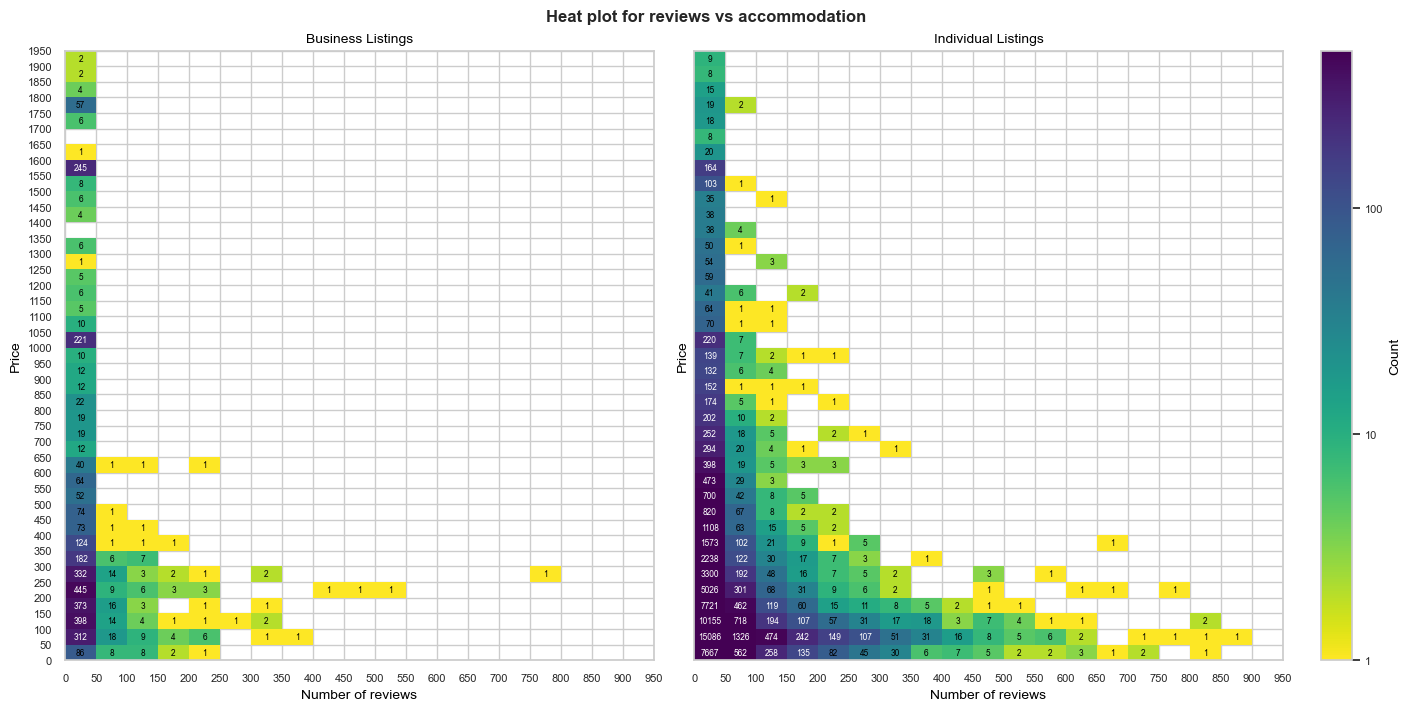

In [71]:
from matplotlib.colors import LogNorm
from matplotlib import ticker

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), squeeze=True, sharex=True, sharey=True, tight_layout=True, layout='constrained')

xbins = np.arange(0, 1000, 50)
ybins = np.arange(0, df_individual['price_mean'].max(), 50)

xticks = np.arange(0, 1000, 50)
yticks = np.arange(0, df_individual['price_mean'].max(), 50)

# define normalization of the colors
h1 = ax1.hist2d(data=df_business, x='number_of_reviews', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=1, vmax=500), cmin=0.5)
# h1 = ax1.hist2d(data=df_business, x='number_of_reviews', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', cmin=0.5)
ax1.set_xticks(xticks, xticks)
ax1.set_yticks(yticks, yticks)

ax1.set_xlabel('Number of reviews')
ax1.set_ylabel('Price')
ax1.set_title('Business Listings', weight='light', fontsize=10)
ax1.set_xlim(0,1000)

h2 = ax2.hist2d(data=df_individual, x='number_of_reviews', y='price_mean', bins=(xbins, ybins), cmap='viridis_r', norm=LogNorm(vmin=1, vmax=500), cmin=0.5)

ax2.set_title('Individual Listings', weight='light', fontsize=10)
ax2.set_xlabel('Number of reviews')
ax2.set_ylabel('Price')



cb2 = fig.colorbar(h2[3], ax=ax2, orientation='vertical', ticks=None)
cb2.set_label('Count', fontsize=10)
cb2.ax.yaxis.set_major_formatter(ticker.ScalarFormatter()) # remove the scientific notation
cb2.ax.yaxis.set_minor_locator(ticker.NullLocator()) # optionally remove the minor ticks


# Add text annotation for plot 1
# Loop through the cell counts and add text annotations for each
counts = h1[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darker cells
            ax1.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax1.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)
            
# Add text annotation for plot 2            
counts = h2[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darker cells
            ax2.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'white', fontsize=6)
        elif c > 0:
            ax2.text(xbins[i]+25, ybins[j]+25, int(c),
                     ha = 'center', va = 'center', color = 'black', fontsize=6)            

plt.suptitle('Heat plot for reviews vs accommodation')

plt.show()

<a id='conclusions'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Conclusions</span>

<blockquote>

**Appoach:**
    
- From univariate exploration, we know that the number of listings per host and minimum nights per rental are the 2 strongest indicators to **detect hosts that are running a business**. In addition I used AI entity recognition from the STANZA package to flag the host name as either a person or business name.
    
- In bivariate exploration, I assess the **impact on price** if the listing is run by a business and long vs short term rentals. 

- In multivariate exploration, we attempt to understand the **behavioral differences** between business and individual rentals. I zoomed into the relationships between key features of interest for businesses and indivuals irrespectively to detect **differences in correlations** between the 2 groups. 

A divergent palette vidiris_r was used consistently, where yellow/light green is used to show low correlation, and dark green/blue to show above average correlations.

**Main findings:**
    
- Only 5% of listings are businesses, focused mainly on holiday rentals, and not people renting homes to live in on a longer basis.
- The average rental price per night from a business host is significantly higher at £450 vs £190.
- Minimum nights are generally <= 7 nights.
- 90% hosts have only 1 or 2 listings.
- Hosts inflate minimum nights (e.g. 600 nights) and price (e.g. > 50k), when they want to avoid renting out a listing, seems like an training issue   
- Businesses are more likely to allow instant_bookable.    
                     
    
    
    
Main features of interest to help detect commercial rentals:
- number of listings per host - hosts with more than 5 listings can surely not be an individual person ?
- type of properties/rooms - commercial listings might focus on renting an entire home or flat
- how many people listings can accommodate
- number of reviews - does commercial listings receive more or less reviews ?
- availability - long term rentals should have less availability if it's rented out for long periods ?
- instantly bookable - commercial rentals for long stay might want to a credit check first ?
- minimum and maximum nights per rental - it's unlikely that a rental with a minimum night of 3 months is a holiday rental
- are the host living in the same area as the rented property ?

Questions to guide the analysis:
- what is the distribution of minimum and maximum nights stay ?
- what kind of properties have minimum stay over 30 days ?
- investigate number of listings per hosts
- what are relationships between minimum nights, number of listings, location of hosts and price ?    
    
    
</blockquote>

<a id='references'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">References</span>

- [white text in pie chart](https://www.tutorialspoint.com/how-to-change-autopct-text-color-to-be-white-in-a-pie-chart-in-matplotlib)
- [interpretting acf and pacf graphs](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
- [formating xaxis date labels](https://stackoverflow.com/questions/56638648/seaborn-barplot-and-formatting-dates-on-x-axis)
- [annotate barplot](https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/)
- [annoate barplot vertical vs horizontal](https://www.kaggle.com/code/asimislam/tutorial-annotate-placing-numbers-on-plots)
- [annotate plot with mean value](https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib)
- [A Little Bit Of Extra Effort Can Hugely Transform Your Basic Matplotlib Plots](https://github.com/ChawlaAvi/Daily-Dose-of-Data-Science/blob/main/Plotting/Professional-Plots-With-Matplotlib.ipynb?utm_source=substack&utm_medium=email)
- [Using NLTP](https://stanfordnlp.github.io/stanza/#getting-started)
- [Annotate grouped bars](https://stackoverflow.com/questions/73491317/how-to-annotate-grouped-bars-with-the-value-and-text-from-a-different-column)
- [hostel business listing taken from](https://www.airbnb.co.uk/rooms/26316886?_set_bev_on_new_domain=1697737032_ZTdhMDk1N2E5MjFh&source_impression_id=p3_1697737032_JIntvD2jJ5%2FBIoXv&check_in=2023-10-26&guests=1&adults=1&check_out=2023-10-28)
- [hostal private listing image taken from](https://www.airbnb.co.uk/rooms/17584230?_set_bev_on_new_domain=1697737032_ZTdhMDk1N2E5MjFh&source_impression_id=p3_1697800369_mfX%2Bxf%2BVlBNMb%2Fs5)
- [set legend symbol opacity](https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity)

<a id='submission'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Submission</span>

In [72]:
# convert notebook to html
os.system('jupyter nbconvert --to html Part_II_exploration.ipynb')

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] WARNING | pattern 'Part_II_exploration.ipynb' matched no files


65280